# Simulation Run Log Analysis and Visualization for AWS DeepRacer

This notebook walks through how you can analyze and debug using the AWS DeepRacer Simulation logs 

```
1. Tools to find best iteration of your model
2. Visualize reward distribution on the track
  2.1 Visualize reward heatmap per episode or iteration
3. Identify hotspots on the track for your model
4. Understand probability distributions on simulated images
5. Evaluation run analysis - plot lap speed heatmap
```

## Requirements

boto3 >= 1.9.133  ; configure your aws cli and/or boto credentials file

AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html

Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

In [2]:
#Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

In [3]:
from log_analysis import *
import cw_utils
import s3_fluent_logs

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [5]:
# Make sure your boto version is >= '1.9.133'
cw_utils.boto3.__version__

'1.9.200'

## Log locations

#### 1. Robomaker: all console output => CloudWatch: dr-sm-rltj--20190904010021-1fa4ce6a-8870-4dec-9ae6-e1d6e28439d2/algo-1-1567558949

AWS DR formatted metrics:

`SIM_TRACE_LOG:0,19,5.9464,-2.3981,-0.2891,-0.17,6.50,7,6.4814,False,True,8.6149,17,22.63,1567600690.766961`

Additional metrics for reward factors:

`s: 0.50, w: 1.00, h: 1.00, t: 1.00, p 1.00, l 1.00`


#### 2. Sagemaker: all console output => Cloudwatch: sim-x5vs3zsfz58c/2019-09-04T12-35-10.611Z_045c7d3d-19cc-4370-b27b-50c40cac3d95/SimulationApplicationLogs

Simulation summary data per episode:

`Training> Name=main_level/agent, Worker=0, Episode=36, Total reward=141.61, Steps=1895, Training iteration=1`

Training summary data per epoch:

`Policy training> Surrogate loss=0.00499933073297143, KL divergence=0.00014034981722943485, Entropy=0.20883481204509735, training epoch=0, learning_rate=3e-06`


#### 3. Robomaker: DR UI metrics => S3: DeepRacer-Metrics/EvaluationMetrics-345864641105-20190904005352-6cc08da6-7027-4219-8672-ac37cf6d2973.json

Used by the DeepRacer web UI for live training chart

Location passed into Robomaker job as `METRICS_S3_BUCKET` `METRICS_S3_OBJECT_KEY`

```
    {
      "start_time": 1567600689419,
      "elapsed_time_in_milliseconds": 9575,
      "reward_score": 703,
      "episode": 1,
      "completion_percentage": 63,
      "metric_time": 1567600698994
    },
```

#### 4. Robomaker: DR ? metrics => ?

Passed into Robomaker starting Sep 4: `METRIC_NAMESPACE: AWSDeepRacer` and `METRIC_NAME: TrainingRewardScore`, perhaps to some new charting solution.  I don't know where these go yet

#### 5. Robomaker: DR Training CSV metrics => S3: DeepRacer-SageMaker-RoboMaker-comm-345864641105-20190904100234-e2f5d094-8936-4f1d-9945-d9c22f3c3dfa/sim_inference_logs/TrainingSimTraceData.csv

Training data:

```
episode,steps,X,Y,yaw,steer,throttle,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,tstamp
0,0,6.169016072954242,2.7164605568250892,-3.1347526172744127,0,0,0,0.75,False,True,0.6866157566413396,1,20.509761133288134,1567591538.5574605
0,1,6.16827601776289,2.716400046493318,-3.134390127931732,-0.5235987755982988,4.0,0,0.03617875646948848,False,True,0.6902272154338266,1,20.509761133288134,1567591538.62269
```

#### 6. Robomaker: DR Evaluation CSV metrics => S3: DeepRacer-SageMaker-RoboMaker-comm-345864641105-20190904100234-e2f5d094-8936-4f1d-9945-d9c22f3c3dfa/sim_inference_logs/EvaluationSimTraceData.csv

Evaluation data:

```
episode,steps,X,Y,yaw,steer,throttle,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,tstamp
0,0,6.165179789216702,2.7158376889540974,-3.1304888595556717,0,0,0,1.0,False,True,0.7053540875373457,1,20.509761133288134,1567599740.5907872
0,1,6.156268337202892,2.7150641498933195,-3.1259899615059688,-0.5235987755982988,4.0,0,1.0,False,True,0.7488443615580477,1,20.509761133288134,1567599740.662083
```

#### 7. Robomaker: DR Submission console output => CloudWatch /aws/deepracer/leaderboard/...sim-5gqd8gzbx8hj/2019-08-31T23-53-33.101Z_35de86c0-2f2c-4bf7-ac2c-b10d3be9ea9e/SimulationApplicationLogs

```
SIM_TRACE_LOG:0,64,5.2115,2.6421,-2.5560,-0.52,6.00,1,0.5000,False,True,34.6526,58,18.24,1567295690.9601312
```


### Download the desired log file given the simulation ID 


If you wish to bulk export the logs from Amazon Cloudwatch to Amazon S3 :: 
https://docs.aws.amazon.com/AmazonCloudWatch/latest/logs/S3ExportTasks.html

In [6]:
# Slowpoke session4
#sim_id = 'sim-pbrc9snyn377'
#stream_name = 'sim-pbrc9snyn377/2019-09-03T22-24-08.859Z_75f33b8b-ff85-4bcf-aace-6f16c0ea010c/SimulationApplicationLogs'

# Slowpoke session5
#sim_id = 'sim-tks2jkdz7hgq'
#stream_name = 'sim-tks2jkdz7hgq/2019-09-06T19-42-21.615Z_50e18599-3dba-460e-9178-7a858d0c8052/SimulationApplicationLogs'

# nu-9-c-a-11
#sim_id = 'sim-y4jyr9lpk7xc'
#stream_name = 'sim-y4jyr9lpk7xc/2019-09-04T01-00-32.192Z_a862a208-bf88-45c3-aa32-0559456fd82b/SimulationApplicationLogs'


#sim_id = 'sim-jg29bmzgd33y'
#stream_name = 'sim-jg29bmzgd33y/2019-10-05T21-12-18.552Z_8a3ddca1-e1a1-43e6-9643-e75343b59504/SimulationApplicationLogs'
#fname = 'logs/deepracer-%s.log' % sim_id
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation
#log_group = '/aws/deepracer/leaderboard/SimulationJobs' # For leaderboard submission
#cw_utils.download_log(fname, stream_prefix=stream_name, log_group=log_group)

# Local training logs source
s3_bucket='aws-deepracer-b6c3c104-eef5-4878-a257-d981cd204d62'

# rho session1
#dirname='logs/20190919200129-9af5dc8a-9f1f-4a7d-9636-3a232e4982a8'
# rho session2
#job_id='20190920034959-45a61e76-338b-484a-9a5e-d6d2bb8169e2'
# rho session3
#job_id='20190920215243-4885bb9b-b2e1-4794-97c6-f7e5297357ee'
# rho session4
#job_id='20190921031417-c714d3f8-68ec-4ebf-a4ae-5874fb66295b'
# rho session5
#job_id='20190921213315-ce4e82ad-0a49-455d-96db-60530be819dd'

# sigma session1
#job_id='20190922051634-7e867c2d-0bfd-4a09-8b48-457f42a4c19b'
# sigma session2
#job_id='20190922133816-89fc7188-1863-4099-a608-6acb09f564a7'
# sigma session3
#job_id='20190923203524-6117734c-3313-479d-9e51-0178c22e04ea'
# sigma session4
#job_id='20190924044742-e6e9527c-2b23-42bf-9e68-cf3847b37dff'
# sigma session5
#job_id='20190924150810-ecbc9bda-b187-4764-bc38-c8723dbe6358'
# sigma session6
#job_id='20190925025206-284f246b-f14e-4e7b-8539-8c960aa75076'
# sigma session7
#job_id='20190925190125-f4d8c1e7-5bb0-4042-bddf-069cc9578c0d'


# tao session1 - 2 hours
#job_id='20190925212114-5cc23004-a075-4546-9ebf-34b7dd5a9b66'
# tao session2 - 2 hours
#job_id='20190925234300-bed6fe63-28c6-4c0e-ad55-9b988038756f'
# tao session3 - 6 hours
#job_id='20190926022938-7450c914-436a-465c-a160-93e3410f8a63'

# upsilon session1
#job_id='20190926110604-6415394d-7e49-4663-a897-f1b2fcd5be27'
# upsilon session2
#job_id='20190926152540-25cb9e49-c489-43e5-9cfa-c2cf869d963b'
# upsilon session2a
#job_id='20190926172942-49341b08-581b-4543-a111-d6e05f320959'
# upsilon session2b
#job_id='20190926201902-10ab5a6b-9790-42a5-aefb-6bca4d4a9ba9'
# upsilon session3
#job_id='20190926221523-38ab4fa9-4f6d-4c96-b91a-4806d536c170'
# upsilon session4
#job_id='20190927030440-be7b49a0-2cb5-4dde-8ba7-044658b1a117'
# upsilon session5
#job_id='20190927103159-75dd7fc7-fd2c-46b3-994e-8017b18bc851'
# upsilon session5a
#job_id='20190927123502-f9234332-bc3b-458b-9c9e-159ec03c5dcc'
# upsilon session6
#job_id='20190927194408-f6d81203-2779-4957-a083-6a208a02ba14'
# upsilon session6a
#job_id='20190927205152-e7eaba40-88a3-4816-aa7d-dda49291f0c3'
# upsilon session6b
#job_id='20190927234649-bdbdd806-0915-4245-b1e9-47960e04e216'

# phi session1
#job_id='20190928144804-59fcc364-70a6-4021-bd41-3c177d80f3ab'
# phi session2
#job_id='20190928193017-fd45a2e4-7ed9-4cc5-a897-5c8fb5df7983'
# phi session3
#job_id='20190928210539-ce07a873-9f09-4df1-8f2d-cde64a6c79b1'
# phi session4
#job_id='20190928230050-a523cba5-0e93-4c2d-b330-42fb20716be0'
# phi session5
#job_id='20190929010129-99f891ad-36d5-4ef7-8a16-5eed2de8417b'
# phi session6
#job_id='20190929030309-7ba66c0b-042c-467f-a850-1276fb438a67'
# phi session7
#job_id='20190929102250-4d7e5a66-c30a-4533-a291-2c9f7cc5c005'
# phi session7a
#job_id='20190929114144-08741eaf-cb43-467c-8e5c-234f9a957c17'
# phi session7b
#job_id='20190929142138-49bd4653-30a6-47cb-851b-590a1b48ceb4'
# phi session8
#job_id='20190929210530-b1feeed7-40a2-4ad8-bfb1-4b70818c5365'
# phi session8a
#job_id='20190929220717-a92b419c-d191-4c3a-99f3-cb0f6acf0576'
# phi session8b
#job_id='20190930002233-c0665935-2574-4e22-9bdd-9fea39ab963a'
# phi session9
#job_id='20190930020236-6fe23fdd-fe37-4a4b-991f-12b3033bb722'
# phi session9b
#job_id='20190930031237-465ead1e-5f81-4d8b-9e88-dc85bb39bf25'
# phi session9c
#job_id='20190930051018-fc9ad243-38c8-4e32-b579-9333d3dc1f0a'
# phi session9d
#job_id='20190930054944-336db066-9376-4934-a8b1-d73c83b78b37'
# phi session9e
#job_id='20190930072916-440ae113-ee04-4070-992b-195992349acf'
# phi session9f
#job_id='20190930124941-1b2fe469-f59a-49fc-9b60-e221746a9983'
# phi session10
#job_id='20190930135317-faba2c16-c9d2-405b-89cf-2f541bfb7926'
# phi session10a
#job_id='20190930143320-77302e7f-1211-4e46-a39f-c34280680bc9'
# phi session9g
#job_id='20190930152022-cc2b171d-d765-4584-8cb2-dae0a4350920'
# phi session9h
#job_id='20190930172632-684c809c-0c0c-4fad-a6c2-fd802ac6b0bc'
# phi session9i
#job_id='20190930180738-6a565fb5-8f9f-40be-8f17-064f789bf5ea'
# phi session9j
#job_id='20190930183958-d5e54987-e574-4392-8a0f-47f288487df5'
# phi session9k
#job_id='20190930191933-1c22b1bd-6117-46cd-b4ea-bb9e3d15f173'
# phi session9l
#job_id='20190930201028-06566817-6a7f-4cb3-9bc8-f01db8e5eaeb'
# phi session10b
#job_id='20190930215408-b49030e3-7d7a-42d3-b3a6-94f252ce356d'
# phi session10c
#job_id='20190930223025-b79c358d-ab38-43a3-8cbe-259594bed951'
# phi session10d
#job_id='20190930232326-11d879f2-f003-462c-8bea-0948aa344f37'

#s3_prefix='training-jobs/%s/logs' % job_id
#log_path='logs/%s' % job_id

In [7]:
#TOR models

# aggressive session1
#job_id='20191002031712-f28730c1-d1f1-4c56-9af3-fcdd109f3b8d'
# aggressive session1b
#job_id='20191002045223-ea305f20-852d-4fb1-abd5-59337a9d751b'

# conservative session1
#job_id='20191002164642-770c3e74-b828-4220-b3d3-c9524f5bb644'
# conservative session2
#job_id='20191002182742-f21666d2-1f6b-484b-98ac-36a299667e2b'
# conservative session3
#job_id='20191002192254-946f04d7-6a28-4b10-bac6-3fcc32aaccf7'
# conservative session3a
#job_id='20191002195359-50cc8262-f34b-45be-8aca-93c49ac92d2e'
# conservative session4
#job_id='20191002204628-f5acaa6b-0918-446f-b767-49228f8415bb'
# conservative session5
#job_id='20191002211615-bb67e6ef-c033-4003-a482-90bf4ca0444b'
# conservative session6
#job_id='20191002224535-7858cb7f-dcd3-45e5-830b-233ee7a7e854'
# conservative session6a
#job_id='20191003001158-8babe209-9b77-470a-afdd-c325f0d1a8d8'
# conservative session3b
#job_id='20191003005931-1762557d-4d02-4512-9e70-5dba5d5aa61c'
# conservative session4b
#job_id='20191003024015-2e5bf26e-0acc-4447-a8df-c3d39cfa5071'
# conservative session9
#job_id='20191003033347-2e55d403-87d5-459b-b2fb-1cef0c948c12'

# conservative session3c
#job_id='20191003091542-bfc09dd9-129d-4497-b3ae-1e431a0b90f9'


#s3_prefix='training-jobs/%s/logs' % job_id
#log_path='logs/%s' % job_id

In [8]:
# OCT models

# == TRAINING (S3) ==

# hydrogen session1
#job_id='20191001173028-e1065687-9b1e-4da3-8198-ca568d436169'
# hydrogen session2
#job_id='20191001204710-88a8faff-1614-4472-afae-bf41ecf4366e'

# helium session1
#job_id='20191005025456-e18514ff-d82a-45d9-a207-0e5cf97a8a11'

# lithium session1
#job_id='20191005200154-5791cfc6-bf12-432a-99a9-f5744436f064'
# lithium session1 evaluation
#job_id='20191006031919-08744401-1add-40fb-b31e-2cf32fbfb92f'

# beryllium session1
job_id='20191006061809-8e5c49d0-0fad-4e0c-8442-169e5b9035e8'
# beryllium session2
#job_id='20191006185231-034742ef-98b1-4260-8dbe-5ce57f2d0128'
# beryllium session2a
#job_id='20191024012240-ddf7a51f-f933-42d8-a8fe-22a8c9ef2de2'
# beryllium session2b
#job_id='20191024040132-0caec3ee-4042-4d4c-bbb3-3cb339fe93e9'
# beryllium session2c
#job_id='20191024055328-4e1e42ef-267a-4203-97b4-45e36c39a217'

# boron session1
#job_id='20191008025653-64f0aff3-567a-4723-bf72-7de777f3ec68'
# boron session2
#job_id='20191008105032-04e2b624-b69f-49f3-bf05-8e6b16cb99fb'
# boron session2 tune6 LOCAL evaluations
#job_id='20191009015016-61e7c132-6622-4f5c-b7e7-1c9966960865'
# boron session3
#job_id='20191009021553-e413e039-8d65-48ba-b008-9434087d3b5b'
# boron session4
#job_id='20191009045238-2a4fed61-dd21-4001-b545-5a149208e738'
# boron session5
#job_id='20191022125114-69ff9001-e097-41f7-a10f-b747110ac950'
# boron session5a
#job_id='20191022164943-eaebf226-6944-4e31-b2ce-f279392b03c9'

# carbon session1
#job_id='20191009202840-46363e50-6bb3-49e5-a368-703e50724ecd'
# carbon session2
#job_id='20191009230130-13c5e5f2-d7db-4e9a-b0b1-ac2a095bb25e'
# carbon session3
#job_id='20191010030345-2fea0ea9-1c64-4c68-b2f0-cbd84c22ee66'
# carbon session4
#job_id='20191010045837-2bea9572-4910-4d9b-9cb1-759fe4ed7a1e'
# carbon session5
#job_id='20191010083013-78c468af-ce05-4515-b2b9-b16cc6fdb3a5'

# nitrogen session1
#job_id='20191011030357-fc1090ba-1c36-4692-9e4b-d9ff7b1a9448'
# nitrogen session2
#job_id='20191011121406-a5713611-be09-4e41-8af5-2ef141ee268e'
# nitrogen session3
#job_id='20191011175139-1fbae2b7-22e2-4505-8fce-9b7b14ac942a'
# nitrogen session4
#job_id='20191012175152-f9364d77-0f50-4b5f-8d77-1f6b4076e884'

# oxygen session1
#job_id='20191014010614-da57e599-4cb1-4077-b866-8cf2a24d0103'

# fluorine session1
#job_id='20191014193905-064a3c9a-e9ae-4f0c-8003-5b24dc66b071'
# fluorine session2
#job_id='20191015112452-8d86fd96-3d47-4df7-a7ee-b5f5a754eb8f'
# fluorine session2, attempt2
#job_id='20191015142029-733ab638-41a3-4c47-8df2-bf629018cc2e'
# fluorine session3
#job_id='20191015195903-c41a5c78-7a45-45ed-b11f-6ddd18036d30'

# neon session1
#job_id='20191015232047-0a2b2ac3-c439-4164-a8a6-dda4c06e3961'
# neon session2
#job_id='20191016023803-5c6082e8-9add-41aa-a67d-10fa55af784d'
# neon session3
#job_id='20191016112849-b9695808-a796-4ddc-b9db-28fba691119a'
# neon session4
#job_id='20191016221427-e1904b57-4b1c-42a2-af9a-8b57e28df8b1'
# neon session4 evaluation
#job_id='20191021042406-978b1c6e-b266-469f-8562-4bb7d69b783e'
# neon session5
#job_id='20191017045625-01d812c8-7190-40e6-8108-f998270b6c43'
# neon session6
#job_id='20191017105820-8752b9f0-6a69-4a1a-99de-319852b3d69c'
# neon session6a
#job_id='20191017164937-e650afbe-5136-4cdf-a665-9543cef2f11d'
# neon session5a
#job_id='20191018001108-1cb256d1-6fcb-4c94-a222-b9cc3a151a44'
# neon session5b
#job_id='20191021063343-07518796-0d03-4561-b566-1470949662dd'
# neon session5c
#job_id='20191024212420-fe0ef79a-a5a4-4dc5-ac09-95ad54bf5809'
  # neon session5c evaluation
#job_id='20191025010408-827c5f69-072d-4971-86c8-4e66ba3f2cb5'

# sodium session1
#job_id='20191018045614-49d06ced-1a4a-41e5-84ce-795e87ec8458'
# sodium session2
#job_id='20191018120257-b39fcdef-bcf7-48bc-bde8-608d42d7daf5'
# sodium session3
#job_id='20191018192546-a57a29ac-9224-4746-8008-d1625f3a7f33'
# sodium session3a
#job_id='20191019000825-1ab77f07-819e-43cc-9451-81ac70063b8b'
# sodium session3b
#job_id='20191019015951-f5a35e1a-4fa0-457a-ad57-867d4041d113'
# sodium session3c
#job_id='20191019124240-4f78dfea-4eac-443f-8115-dd009945ced1'
# sodium session3c2
#job_id='20191019184547-8870d398-16d2-45f1-9cd5-ed45b8d78c9c'
# sodium session3d
#job_id='20191019200433-b3fb6c3c-37f8-4a62-8f8b-909c6c526511'

# magnesium session1
#job_id='20191019233703-3408c858-3848-468c-abcf-cbe6b667e526'

# aluminum session1
#job_id='20191020095610-2678ddf9-fdee-4c23-9fea-ad26e72358bc'

# silicon session1
#job_id='20191020132015-b14d2fe4-594a-43bb-9b90-a15acf91e845'
# silicon session2
#job_id='20191020145950-3c485793-1c99-40d9-a619-8c29110e8e20'
# silicon session3
#job_id='20191020170733-1268a03f-0bdd-4c31-8606-4e56c2c08581'
# silicon session3a
#job_id='20191020201244-8536ea33-2e17-4f61-9225-d054e26560fb'

# phosphorous session1
#job_id='20191022202052-f39c9859-0103-4aa6-82bf-b9250483b5df'

# sulfer session1
#job_id='20191023114407-f54f48ff-20f5-4c9a-8ad4-9fcceb09d22b'
# sulfer session2
#job_id='20191023204625-ba52682c-aeba-428e-9f0e-4287c25dc51e'

# chlorine session1
#job_id='20191024112306-259e095a-09d8-46df-8305-8c28f429e0e7'
# chloring session2
#job_id='20191024130245-f09b039f-adb3-44a8-8ff8-8e0bec8029fc'

# argon session1
#job_id='20191024152818-d890fa93-c0bb-405e-9acf-b28b5f2f45af'
# argon session1a
#job_id='20191024161749-a7c39285-68a7-4bbc-ac25-4ca21b5f5c98'

# potassium session1
#job_id='20191025074400-b284da1a-abe2-498d-acba-4af02089dd76'
# potassium session2
#job_id='20191025114829-56b5b6b5-87fe-4aff-958b-0a23d04dfc46'
# potassium session3
#job_id='20191025151701-9d273cd3-3959-4770-9606-8baec6b05b3d'
# potassium session3a
#job_id='20191025172404-620e4e9d-7cba-4585-9114-b1ab877ab25b'
# potassium session3a2
#job_id='20191025195026-377a9704-e10b-4a8d-8384-70fd76d007bb'
# potassium session3a3
#job_id='20191025212809-899c30d2-7a69-4003-a047-f455a6cad6a5'
# potassium session3a4
#job_id='20191026000855-bbc3b77e-6676-43d1-94b3-0ab9392caddf' # false start
#job_id='20191026002459-b9b798e1-f5be-4ab1-94f3-65391a175aad'
# potassium session3a5
#job_id='20191026023230-d0c53498-45ae-4744-8e78-2275febf8222'
# potassium session3a6
#job_id='20191026123511-2ea897cb-d113-4eb2-97f9-6af965b8da64'
# potassium session3a7
#job_id='20191026153407-4e0e8d5d-e64f-43f2-a9b3-46232241cfc3'
#job_id='20191026164607-cd245895-f30b-40bc-aaa4-356195052214' # 2nd attempt to avoid NaN
# potassium session3a7a
#job_id='20191026170808-b3ed77e3-d84f-459b-a8c2-e7bbe7b40c99'
# potassium session3a4a
#job_id='20191027024540-92d9fa8a-6217-440e-a05d-38bc40538cd4' # NaN after 5 iterations
#job_id='20191027031502-e94d7473-0dd1-4929-a489-035be500cf11'
# potassium session3a4a2
#job_id='20191027044332-b9ce2f6a-a2a7-4064-9951-8d0b4d7d35bf'


# calcium
#job_id='20191025192033-ed98a405-9db6-4ad0-a541-d036740dff15'
# calcium session3 (test canada track at low rtf)
#job_id='20191027004646-5964cfc0-5f02-4a49-ab8d-3bfccd86cd24'
# calcium session4 (compare low rtf to dropout rate at full rtf)
#job_id='20191027005857-de5a647f-e7d2-491f-a274-ef5acbd32b33'
# calcium session5
#job_id='20191027021848-a32a8a8f-4ba4-4869-9b0b-a33e64fd7f9d'

# scandium session1
#job_id='20191027135600-2801cf4b-a2e0-49b7-930f-3b36b03aec5b'
# scandium session2
#job_id='20191027160248-2150a288-a470-4681-8e56-def0a3d622b3'
# scandium session3
#job_id='20191027180957-e61176f1-e87f-4dac-bf2b-5969e19f6e81'
# scandium session4
#job_id='20191027215125-0b258531-3a7a-422b-b05d-95a7e09b05aa'

# titanium session1
#job_id='20191028022550-54e1a51a-4ef6-487e-87c9-3b136ee5ac0d'
# titanium session2
#job_id='20191028043752-d65004f8-daf5-4895-a546-f0c03d0614b0'
# titanium session3
#job_id='20191028064447-0c43cd34-2319-48de-ad59-ebd2fa0acb55'
# titanium session4
#job_id='20191028090818-0a75d478-3169-4e6d-b278-19793262bb9e'
# titanium session5
#job_id='20191028132603-f7a3633a-0a98-42e7-8d98-df854bf58c72'
# titanium session6
#job_id='20191028143725-f8ead146-bfa0-416c-b789-591eb0d35bdd'
# titanium session7
#job_id='20191028180015-ca33f260-cee6-443a-b213-f6f9ff6339cd'
# titanium session8
#job_id='20191028204334-e9ec749c-4c48-4150-a770-968f445b3ab2'
# titanium session9
#job_id='20191029000838-356b7bc2-e0d5-4716-9b28-e56fcdd9ad1a'
# titanium session10
#job_id='20191029014839-f13c17e7-3949-4209-8c9d-88c9339212a9'
# titanium session9a
#job_id='20191029144315-a7ec92ec-bf81-4878-8c6e-ba0fdacafa5d'
# titanium session9b
#job_id='20191029154023-d0f7789a-269e-4efb-8d53-73a45749dc6f'
# titanium session9c
#job_id='20191029161927-42ec03d7-1767-4aef-9266-e9ae931d693d'
# titanium session9d
#job_id='20191029174012-72a31826-caf8-49a4-8737-f53960b1a70d'
# titanium session9d2
#job_id='20191029210237-e7dc9122-2b18-4581-8f44-62401205a797'
# titanium session9d2a
#job_id='20191029213154-b68b9af2-caaf-4a05-82de-7c63b3b1514e'
# titanium session9d2a2
#job_id='20191029224716-68807a68-70d3-4519-a628-3867f31739d1'
# titanium session9d2a3
#job_id='20191030111648-62260e64-30f2-4818-8923-e763e55e941e'
# titanium session9d2b
#job_id='20191030172131-278dc004-db71-4d81-abd2-b87402cd3164'
# titanium session9d2c
#job_id='20191030180509-ebb212ae-a546-433b-9f4d-c9a37c1e572d'
# titanium session9d2c2
#job_id='20191030203345-5e8bb5a3-9470-4c6e-a542-69f61933a779'
# titanium session9d2c3
#job_id='20191030230701-64e59fa1-a666-48e5-b429-3fbdb2ba6c3e'
# titanium session9d2c4
#job_id='20191031003500-f6a99c47-e6c5-4561-9486-a9df051011f4'
# titanium session9d2c5
#job_id='20191031033023-8015b913-5963-43eb-9b19-5dba76aaa794'
# titanium session9d2c6
#job_id='20191031111718-cc7457aa-ba23-46d7-88e2-84823f980858'
# titanium session9d2c7
#job_id='20191031130614-2835ce7f-2c6b-43e3-9f61-7a784080494c'
# titanium session9d2c8
#job_id='20191031143037-6efb6506-be51-42f6-8497-c7922d54f2d1'

#s3_prefix='training-jobs/%s/logs' % job_id
#log_path='logs/%s' % job_id
#s3_fluent_logs.download_logs(s3_bucket, s3_prefix, log_path)

# == EVALUATION & SUBMISSION (Cloudwatch) ==

# beryllium untuned submission
#sim_id = 'sim-tk52sn1wh94m'
#stream_name = 'sim-tk52sn1wh94m/2019-10-06T11-44-22.489Z_8ed26edf-2d67-47ef-a225-069da55e654a/SimulationApplicationLogs'
#log_group = '/aws/deepracer/leaderboard/SimulationJobs' # For leaderboard submission

# beryllium tune1 evaluation
#sim_id='sim-35jwtw8fsw5k'
#stream_name='sim-35jwtw8fsw5k/2019-10-06T12-58-45.715Z_24001a8c-3d0b-477e-81bb-aa11dd6f261f/SimulationApplicationLogs'
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation

# beryllium tune1 submission
#sim_id='sim-f3114pnh1z80'
#stream_name='sim-f3114pnh1z80/2019-10-06T13-00-37.188Z_905090b3-e338-4c80-b8e9-2fae8769fc8a/SimulationApplicationLogs'
#log_group = '/aws/deepracer/leaderboard/SimulationJobs' # For leaderboard submission

# beryllium tune2 evaluation
#sim_id='sim-tv6p279mslhh'
#stream_name='sim-tv6p279mslhh/2019-10-06T14-19-38.551Z_b42660ff-0a70-488a-8f7d-036c710155d9/SimulationApplicationLogs'
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation

# beryllium tune2 submission
#sim_id='sim-h1j88q8z21yc'
# no successful laps
#stream_name='sim-h1j88q8z21yc/2019-10-06T14-21-29.793Z_dcf6c0df-177d-4147-bc6c-8e480605edbe/SimulationApplicationLogs'
# at least 1 successful lap
#sim_id='sim-sh58xdh730gw'
#stream_name='sim-sh58xdh730gw/2019-10-06T15-25-23.429Z_2db7c016-3caf-4400-9da9-3110e6865008/SimulationApplicationLogs'
#log_group = '/aws/deepracer/leaderboard/SimulationJobs' # For leaderboard submission

# beryllium tune3 evaluation
#sim_id='sim-9w884qct6358'
#stream_name='sim-9w884qct6358/2019-10-06T16-13-51.595Z_11c68df9-e4c2-4f27-83f4-b53b9894a369/SimulationApplicationLogs'
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation
# beryllium time3 submission
#sim_id='sim-1zb3qhbfyn3f'
#stream_name='sim-1zb3qhbfyn3f/2019-10-06T16-15-39.280Z_361fe4be-ad26-4301-b9ff-08fd82e2f4b5/SimulationApplicationLogs'
#log_group = '/aws/deepracer/leaderboard/SimulationJobs' # For leaderboard submission

# beryllium tune4 evaluation
#sim_id=''
#stream_name='sim-vqgvfp05t6kv/2019-10-06T16-46-22.105Z_ca83bf03-dc97-42a7-b478-fcc509c8ac97/SimulationApplicationLogs'
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation
# beryllium tune4 submission
#sim_id='sim-xlgt8xr9bp1s'
#stream_name='sim-xlgt8xr9bp1s/2019-10-06T16-51-25.404Z_acb960d1-b795-48ad-ae0c-0bae47f02222/SimulationApplicationLogs'
#log_group = '/aws/deepracer/leaderboard/SimulationJobs' # For leaderboard submission

# beryllium tune5 evaluation
#sim_id='sim-1fhg1s62kxc9'
#stream_name='sim-1fhg1s62kxc9/2019-10-06T17-02-03.915Z_34dd1177-35c7-44d7-8bdf-7b4f35900a19/SimulationApplicationLogs'
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation
# beryllium tune5 submission
#sim_id='sim-87qd2wxd9xmz'
#stream_name='sim-87qd2wxd9xmz/2019-10-06T17-23-07.795Z_b31017b2-c3e9-40c0-a5dc-e9bf0426b6ec/SimulationApplicationLogs'
#log_group = '/aws/deepracer/leaderboard/SimulationJobs' # For leaderboard submission

#beryllium tune6 evaluation
#sim_id='sim-lcngrtwd4nfs'
#stream_name='sim-lcngrtwd4nfs/2019-10-06T17-47-44.584Z_1f3e1549-d767-4a5f-bd77-ad5c73a943ec/SimulationApplicationLogs'
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation
# beryllium tune6 submission
#sim_id='sim-m03f20qb2q36'
#stream_name='sim-m03f20qb2q36/2019-10-06T18-02-52.084Z_bfe77328-049d-450b-a0aa-e1c6a8c02bb8/SimulationApplicationLogs'
#log_group = '/aws/deepracer/leaderboard/SimulationJobs' # For leaderboard submission

#beryllium tune7 evaluation
#sim_id='sim-qbjf99954pkr'
#stream_name='sim-qbjf99954pkr/2019-10-06T18-34-36.361Z_d32fca8d-6f94-4101-a743-3ee156c6eda7/SimulationApplicationLogs'
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation
#beryllium tune7 submission
#sim_id='sim-gjh7vtz5z435'
#stream_name='sim-gjh7vtz5z435/2019-10-06T18-36-13.109Z_b74df76c-16c9-4028-9972-5f6167d99d58/SimulationApplicationLogs'
#log_group = '/aws/deepracer/leaderboard/SimulationJobs' # For leaderboard submission

#beryllium tune9 evaluation
#stream_name='sim-k8wg9wtcq94z/2019-10-07T01-44-33.994Z_a464127c-a3b2-458d-ae61-ddc4595e3107/SimulationApplicationLogs'

# beryllium tune10 evaluation
#stream_name='sim-yg6bwvqzm0rd/2019-10-07T01-56-04.440Z_9d5f4372-d826-48cb-8387-f3fef6a6da72/SimulationApplicationLogs'

#beryllium tune11 evaluation
#stream_name='sim-bmhn3tphvq5m/2019-10-07T02-04-57.384Z_6425a797-7bc2-4750-aafe-1fb83a978190/SimulationApplicationLogs'

# beryllium session2 evaluation (checkpoint 58)
#sim_id='sim-0g056pkk8zzv'
#stream_name='sim-0g056pkk8zzv/2019-10-06T22-28-10.934Z_d218e86e-b194-4fb9-a2fd-cef20991a895/SimulationApplicationLogs'
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation


# boron session1 evaluation
#sim_id='sim-7ky5fsxy736x'
#stream_name='sim-7ky5fsxy736x/2019-10-08T05-39-26.928Z_65bca7ed-9e65-48f9-be48-8230b8b644fd/SimulationApplicationLogs'
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation

# boron session2 evaluation (checkpoint 45)
#sim_id='sim-qjn1zw3hvnsb'
#stream_name='sim-qjn1zw3hvnsb/2019-10-08T16-09-40.324Z_c800ee19-a090-4ac5-89eb-82a0566112ef/SimulationApplicationLogs'
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation

# boron session2 evaluation (checkpoint 45) second pass
#sim_id='sim-0yxzjj7thpkv'
#stream_name='sim-0yxzjj7thpkv/2019-10-08T16-52-12.102Z_0abec6d1-55bf-46a5-96cb-888cefff079d/SimulationApplicationLogs'
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation

# boron session2 tune1 evaluation
#sim_id='sim-lh7znlpn8lnh'
#stream_name='sim-lh7znlpn8lnh/2019-10-08T17-44-57.659Z_0e0ffeb7-901b-496d-b108-63e129466d02/SimulationApplicationLogs'
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation

# boron session2 tune2 evaluation
#sim_id='sim-1ff4kh17y72j'
#stream_name='sim-1ff4kh17y72j/2019-10-08T18-06-53.043Z_0c05b57b-2eb4-4011-bd0e-e089347acb68/SimulationApplicationLogs'
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation

# boron session2 tune3 evaluation
#sim_id='sim-kb09x0bcddq9'
#stream_name='sim-kb09x0bcddq9/2019-10-08T18-22-52.825Z_71ccef01-37aa-4b52-9042-5b0d56261235/SimulationApplicationLogs'
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation

# boron session2 tune4 evaluation
#sim_id='sim-ykg3thhdqp60'
#stream_name='sim-ykg3thhdqp60/2019-10-08T19-12-22.132Z_dbf67c8d-d9ae-43eb-af36-3ec21f60c365/SimulationApplicationLogs'
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation

# boron session2 tune5 evaluations
#sim_id='sim-dt9qh8hqd53z'
#stream_name='sim-dt9qh8hqd53z/2019-10-08T19-52-37.520Z_a223c85b-57eb-4d8a-9f78-8fba5d88c998/SimulationApplicationLogs'
#sim_id='sim-x6v1sfn3v8mf'
#stream_name='sim-x6v1sfn3v8mf/2019-10-08T20-12-28.246Z_c9f7af08-52a2-4eb9-b554-6a5d2c9f034f/SimulationApplicationLogs'
#sim_id='sim-p20z9gdzxqkn'
#stream_name='sim-p20z9gdzxqkn/2019-10-08T20-58-10.923Z_f9c92b61-2188-4be0-8f89-4699c0aa9c41/SimulationApplicationLogs'
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation

# boron session2 tune6 evaluations
#sim_id=''
#stream_name='sim-3t1hl3jwwlrn/2019-10-09T01-47-22.666Z_4bf96b91-7a2d-4329-ab59-c8af291d6324/SimulationApplicationLogs'
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation
#sim_id='sim-nr5f5htjff4d'
#stream_name='sim-nr5f5htjff4d/2019-10-09T01-50-30.806Z_736f27df-5dc3-4f14-94f9-2ab1b27a2da9/SimulationApplicationLogs'
#log_group = '/aws/deepracer/leaderboard/SimulationJobs' # For leaderboard submission

# boron session4 evaluation
#sim_id='sim-x7qx977f6prj'
#stream_name='sim-x7qx977f6prj/2019-10-09T11-01-19.488Z_54e57c63-d9c7-4c34-975c-a44c0e5bd2fb/SimulationApplicationLogs'
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation

# boron session4 submission
#sim_id='sim-42wny15pvb9n'
#stream_name='sim-42wny15pvb9n/2019-10-09T12-48-45.966Z_0ab4cc86-50dc-4326-b37b-f1055a593531/SimulationApplicationLogs'
#log_group = '/aws/deepracer/leaderboard/SimulationJobs' # For leaderboard submission

# boron session4 tune1 evaluation
#sim_id='sim-c4fj7df3xpm6'
#stream_name='sim-c4fj7df3xpm6/2019-10-09T16-24-53.408Z_c248a107-09a7-407e-b310-41173e422a31/SimulationApplicationLogs'
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation

# carbon session2 evaluation
#sim_id='sim-808mgw7knpjt'
#stream_name='sim-808mgw7knpjt/2019-10-10T01-36-49.405Z_f8e49d52-08f4-4b2c-9965-9963b0eeab00/SimulationApplicationLogs'
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation

# carbon session5 evaluation
#sim_id='sim-ctvxbxxp6zc'
#stream_name='sim-ctvxbxxp6zcm/2019-10-10T17-23-51.744Z_2956d026-b4d1-4e27-9b74-3583153f15ac/SimulationApplicationLogs'
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation

# carbon session5 submission
#sim_id='sim-7f07mhjkthrb'
#stream_name='sim-7f07mhjkthrb/2019-10-10T17-16-49.694Z_4ca2ab67-f4cb-49ad-8a49-e5a6e585e6e1/SimulationApplicationLogs'
#sim_id='sim-k2d96ggw8nvx'
#stream_name='sim-k2d96ggw8nvx/2019-10-10T18-26-43.578Z_bfd7b2d0-ae7c-457c-85c5-d00e03ca1c40/SimulationApplicationLogs'
#log_group = '/aws/deepracer/leaderboard/SimulationJobs' # For leaderboard submission

# carbon session5 tune 1 evaluation
#sim_id='sim-f0cl3qg8qvmd'
#stream_name='sim-f0cl3qg8qvmd/2019-10-10T19-05-42.017Z_1ee73afe-ad55-4df1-abb3-e076d748b1bd/SimulationApplicationLogs'
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation

# carbon session5 tune 2 evaluation
#sim_id='sim-p8xk881lnm2t'
#stream_name='sim-p8xk881lnm2t/2019-10-10T19-13-31.087Z_83e570f9-919a-46b1-975e-ea1f929f4768/SimulationApplicationLogs'
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation

# carbon session5 tune 3 evaluation
#sim_id='sim-d0bm3cr1ymzk'
#stream_name='sim-d0bm3cr1ymzk/2019-10-10T19-22-38.361Z_22ce7a52-d5d9-452b-949b-26e7f7296e51/SimulationApplicationLogs'
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation

# carbon session5 tune 4 evaluation
#sim_id='sim-63k24xb65dkf'
#stream_name='sim-63k24xb65dkf/2019-10-10T19-46-26.462Z_98e0fe3d-a466-4b02-90fc-12058b217913/SimulationApplicationLogs'
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation
#sim_id='sim-qyfr2nl71vgc'
#stream_name='sim-qyfr2nl71vgc/2019-10-10T19-54-49.622Z_71efd4a1-f1e0-4491-9e0a-2096ce6cc573/SimulationApplicationLogs'
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation

# carbon session 5 tune 6 evaluation
#sim_id='sim-2j2sk80kb7hs'
#stream_name='sim-2j2sk80kb7hs/2019-10-10T20-11-53.303Z_4bd71f6d-38a5-45dc-8751-fa9f394fea8d/SimulationApplicationLogs'
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation

# neon session 5 evaluation
#sim_id='sim-2m67bmnzggkv'
#stream_name='sim-2m67bmnzggkv/2019-10-17T13-00-33.886Z_c55a5540-c6d9-440b-81e0-f6088dcc34a0/SimulationApplicationLogs'
#log_group = '/aws/deepracer/leaderboard/SimulationJobs' # For leaderboard submission

# neon session 5 submission
#sim_id='sim-y9hst5l51fkt'
#stream_name='sim-y9hst5l51fkt/2019-10-17T14-46-03.230Z_be02f454-9b95-4033-94ab-44df9c50ed0e/SimulationApplicationLogs'
#log_group = '/aws/deepracer/leaderboard/SimulationJobs' # For leaderboard submission

# neon session5a evaluation
#sim_id='sim-wg8m27h5nzgl'
#stream_name='sim-wg8m27h5nzgl/2019-10-18T04-46-23.748Z_95e2474e-2c23-4b7e-9813-142f93ea9d6c/SimulationApplicationLogs'
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation

# neon session? evaluation
#sim_id='sim-jmkplkgfjjf0'
#stream_name='sim-jmkplkgfjjf0/2019-10-19T00-08-11.454Z_09600948-127b-408f-8547-34917d306961/SimulationApplicationLogs'
#log_group = '/aws/deepracer/leaderboard/SimulationJobs' # For leaderboard submission

# neon session5a submission
#sim_id='sim-pwdhgkxj8y48'
#stream_name='sim-pwdhgkxj8y48/2019-10-19T11-06-06.739Z_21fb730c-fc3c-4d3a-8608-bca26bd1519a/SimulationApplicationLogs'
#log_group = '/aws/deepracer/leaderboard/SimulationJobs' # For leaderboard submission

# sodium session 2 evaluation
#sim_id='sim-yn6gchlyhm63'
#stream_name='sim-yn6gchlyhm63/2019-10-18T15-52-21.015Z_fae37d1c-def7-4e43-af3a-eb0c49be78b3/SimulationApplicationLogs'


# neon session 5 tune 1 evaluation
#sim_id='sim-3kts44n4gd36'
#stream_name='sim-3kts44n4gd36/2019-10-26T02-56-59.771Z_532d80e8-0286-4644-92d8-c84990509474/SimulationApplicationLogs'
#sim_id='sim-0fggqckpg5zf'
#stream_name='sim-0fggqckpg5zf/2019-10-26T03-08-45.606Z_21e2b3d1-ff90-4271-aa2f-784a6d0098ef/SimulationApplicationLogs'

# neon session 5 tune 2 evaluation
#sim_id='sim-8cxp3sm4jhkh'
#stream_name='sim-8cxp3sm4jhkh/2019-10-26T03-30-14.342Z_7df708b9-bba6-4a93-b7b6-2d7a9ee7bc99/SimulationApplicationLogs'
#sim_id='sim-xpfkly1fw1ws'
#stream_name='sim-xpfkly1fw1ws/2019-10-26T03-42-49.072Z_17635bb6-71ea-41bc-81f6-ae274ad59bc8/SimulationApplicationLogs'

# neon session5 tune 3 evaluation
#sim_id='sim-g3zsb0kv2vst'
#stream_name='sim-g3zsb0kv2vst/2019-10-26T03-57-37.709Z_b28d58ed-9ec0-4dd1-91c2-30c863876a3e/SimulationApplicationLogs'

# neon session5 tune 4 evaluation
#sim_id='sim-s0zx5lfq79rh'
#stream_name='sim-s0zx5lfq79rh/2019-10-26T04-21-36.666Z_a87b8738-fc27-43aa-9c75-427bc61eacf0/SimulationApplicationLogs'
#sim_id='sim-2qt0b81mbw68'
#stream_name='sim-2qt0b81mbw68/2019-10-26T04-30-55.010Z_92e832f9-d3bf-4f17-a119-95996b89cc67/SimulationApplicationLogs'

# neon session5 tune 5 evaluation
#sim_id='sim-fp6dsrsr3dnl'
#stream_name='sim-fp6dsrsr3dnl/2019-10-26T04-40-32.567Z_f1d23b37-8f77-42b2-a456-d7cd1db59e61/SimulationApplicationLogs'

# neon session5 tune 1 submission
#sim_id='sim-hbsnxrp2m1ng'
#stream_name='sim-hbsnxrp2m1ng/2019-10-26T14-08-24.633Z_36e6e547-8a63-4361-898e-09f924f5536b/SimulationApplicationLogs'

# potassium 3a7 tune1 submission
#sim_id='sim-4p2qg8wdnn8b'
#stream_name='sim-4p2qg8wdnn8b/2019-10-27T00-08-59.620Z_98ebc339-7b8c-4a15-b7c2-08c1f43c5647/SimulationApplicationLogs'

# scandium session3 evaluation (3/5 completion)
#stream_name='sim-mtp9vcfvwhwq/2019-10-27T20-31-30.284Z_0fe37047-3744-442b-b163-71bc1781b28d/SimulationApplicationLogs'
# scandium session3 evaluation (0/5 completion)
#stream_name='sim-vxk14kl8z11s/2019-10-27T21-18-36.827Z_d2f4216b-ce33-437c-9878-6700ceb3ceeb/SimulationApplicationLogs'
# scandium session3 evaluation (1/5 completion)
#stream_name='sim-dc2wtx74xdf8/2019-10-27T21-40-54.712Z_b5019c61-765d-454e-bd3a-5d9ed037dbc2/SimulationApplicationLogs'

# titanium session6 tune1 submission (1/5 complete laps)
#sim_id='sim-zj5q81v8nn65'
#stream_name='sim-zj5q81v8nn65/2019-10-28T19-27-50.421Z_2823ce7f-5f15-4bca-b40b-88a91598d217/SimulationApplicationLogs'
#sim_id='sim-nr33hxn32xfg'
#stream_name='sim-nr33hxn32xfg/2019-10-28T20-35-29.313Z_ac1e8186-3cf2-4b99-8824-d5c5e0e0dc44/SimulationApplicationLogs'
#log_group = '/aws/deepracer/leaderboard/SimulationJobs' # For leaderboard submission


# titanium submission (0 complete laps)
#sim_id='sim-h5vt1gxhtc6f'
#stream_name='sim-h5vt1gxhtc6f/2019-10-30T01-00-12.460Z_1649705b-6791-420a-80b9-9608769baf9f/SimulationApplicationLogs'
#sim_id='sim-6tm9fbz66x34'
#stream_name='sim-6tm9fbz66x34/2019-10-30T01-35-22.699Z_e4632aa6-fdb2-467d-9ff1-a3fa50961712/SimulationApplicationLogs'
#log_group = '/aws/deepracer/leaderboard/SimulationJobs' # For leaderboard submission

# titanium 9d2a2 (0 complete laps)
#sim_id='sim-t6f0326msqgp'
#stream_name='sim-t6f0326msqgp/2019-10-30T11-01-29.891Z_ee67f263-6984-4b8f-84fd-6c645149feb5/SimulationApplicationLogs'
#log_group = '/aws/deepracer/leaderboard/SimulationJobs' # For leaderboard submission

# titanium 9d2c3 evaluation (0 complete laps)
#sim_id='sim-m88k12drqxzt'
#stream_name='sim-m88k12drqxzt/2019-10-31T00-31-09.311Z_2dac0216-7e69-4ed3-acc1-5d8de30740af/SimulationApplicationLogs'

# titanium 9d2c4 submission (0 complete laps)
#sim_id='sim-6p3qxj527pq6'
#stream_name='sim-6p3qxj527pq6/2019-10-31T02-47-12.248Z_4d569dc6-14ad-434c-8528-2432c1d8168f/SimulationApplicationLogs'
#log_group = '/aws/deepracer/leaderboard/SimulationJobs' # For leaderboard submission

fname = 'logs/deepracer-%s.log' % sim_id
#log_group = '/aws/robomaker/SimulationJobs' # For training and evaluation
#log_group = '/aws/deepracer/leaderboard/SimulationJobs' # For leaderboard submission

cw_utils.download_log(fname, stream_prefix=stream_name, log_group=log_group)


NameError: name 'sim_id' is not defined

In [71]:
# NOV models

# augustus session1
#job_id='20191105184152-b805bb5a-42ba-45e2-a69e-b2f535c9ed70'
# augustus session2
#job_id='20191105204433-57f49da5-1f57-4ed8-9fe3-280fd9821ec6'
# augustus session3
#job_id='20191105225417-9722d125-a863-4cc4-bd97-7399fd940ae0'

# tiberius session1
#job_id='20191107141302-0a7a2a43-b121-47dc-8f89-92cde2a460ba'
# tiberius session2
#job_id='20191113212543-faa988d3-31a5-453c-ae6c-cfb7806c7fb5'
# tiberius session3
#job_id='20191113235633-f3bf89ee-88be-4edf-88df-df6312f9455a'
# tiberius session3a
#job_id='20191114030939-14ad716e-bcad-465c-87b1-117a2e718f88'
# tiberius session3b
#job_id='20191114141858-199b2f77-14ca-4beb-b24f-a0783789a07b'
# tiberius session3b2
#job_id='20191116152803-a9744a91-9113-4e00-a344-1c48f595629a'
# tiberius session3b2a
#job_id='20191116180749-c7053dad-2c30-4788-9ced-ccf34a6fa3a6'
# tiberius session3b2b
#job_id='20191116200632-3a205320-4f51-46eb-a50e-6a6f90204d1f'

# tiberius session3c
#job_id='20191114154902-1962b157-d62d-4eef-a893-010463170211'


# caligula session1
#job_id='20191107184531-12680656-611c-4776-9bc8-42dd97c90516'
# caligula session1a
#job_id='20191107193323-c1825178-5bb6-44a6-9ffc-9886697d7617'
# caligula session1a2
#job_id='20191107231450-f882e26c-7a99-49e3-b351-840667ad797d'

# Claudius is A/B test for image perturbations
# claudius no-mods
#job_id='20191110045154-91e80226-86b5-41fc-8ea2-37bdc070dfcd'
# claudius with-mods
#job_id='20191112050205-8f08b43c-93c6-40df-8ab5-e7ff43813080'

# nero session1
#job_id='20191121194910-d7442c81-7966-4ed3-bf23-22d93fcfbed3'
# nero session1a
#job_id='20191122140743-8e69f32d-3ed4-4ef9-ab78-1c338bcdb59f'
# nero session1b
#job_id='20191124123204-f86d7945-d893-43fe-ae92-9be63442f736'
# nero session1c
#job_id='20191124225016-bdc2909c-e270-47e2-84d3-97084b68ef12'
# nero session1d
#job_id='20191125220919-8e5a9da1-9d2d-410f-8c51-fd19bf7d75d6'
# nero session1e
job_id='20191126232543-1d063616-b927-4eab-8fe1-e3627a955d20'

# galba session1
#job_id='20191128021150-74c993f8-98d8-46d0-be59-e6736942d664'
# galba session2d
#job_id='20191128052645-ff18cb68-cbcd-4448-8ac0-41513cbfba73'
# galba session3
#job_id='20191207171918-44d0924f-f9d6-464e-b74f-32944de8344c'
# galba session3a
#job_id='20191208005604-1427b7f7-2119-4308-b0a3-69cbbb9189a7'
# galba session3b
#job_id='20191208021239-edcbf3f2-8b5e-4896-9b15-553eb9054daa'
# galba session3b2
#job_id='20191208164910-49e15884-21d2-43dc-9a95-c6ba95581d2b'


s3_prefix='training-jobs/%s/logs' % job_id
log_path='logs/%s' % job_id
s3_fluent_logs.download_logs(s3_bucket, s3_prefix, log_path)

Found 114 files in s3://aws-deepracer-b6c3c104-eef5-4878-a257-d981cd204d62/training-jobs/20191126232543-1d063616-b927-4eab-8fe1-e3627a955d20/logs
Skipping previously downloaded file 20191126_0.json
Skipping previously downloaded file 20191126_1.json
Skipping previously downloaded file 20191126_10.json
Skipping previously downloaded file 20191126_11.json
Skipping previously downloaded file 20191126_2.json
Skipping previously downloaded file 20191126_3.json
Skipping previously downloaded file 20191126_4.json
Skipping previously downloaded file 20191126_5.json
Skipping previously downloaded file 20191126_6.json
Skipping previously downloaded file 20191126_7.json
Skipping previously downloaded file 20191126_8.json
Skipping previously downloaded file 20191126_9.json
Skipping previously downloaded file 20191127_0.json
Skipping previously downloaded file 20191127_1.json
Skipping previously downloaded file 20191127_10.json
Skipping previously downloaded file 20191127_100.json
Skipping previous

# Training Worker Stats

For PPO we have:

1. Surrogate Loss
2. KL Divergence
3. Entropy

These should all fluctuate but Surrogate Loss should tend toward zero.  Entropy will also tend towards zero.  

In [72]:
df = s3_fluent_logs.extract_training_epochs(log_path)
#df.tail(30)

(250, 6)


Text(0.5, 1.0, 'Entropy')

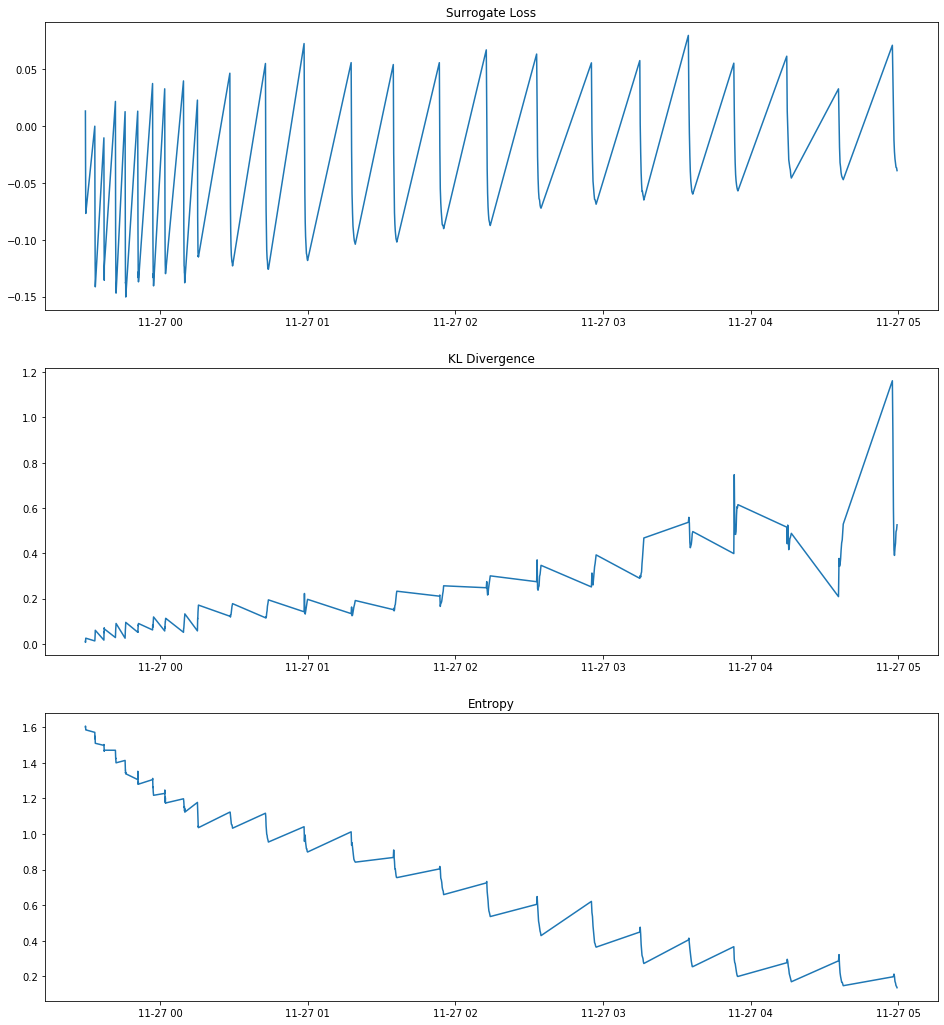

In [73]:
final_epochs = df.tail(1000)
print(df.shape)

fig = plt.figure(figsize=(16, 18))
ax = fig.add_subplot(311)
ax.plot(final_epochs['timestamp'],final_epochs['surrogate_loss'])
ax.set_title('Surrogate Loss')
ax = fig.add_subplot(312)
ax.plot(final_epochs['timestamp'],final_epochs['kl_divergence'])
ax.set_title('KL Divergence')
ax = fig.add_subplot(313)
ax.plot(final_epochs['timestamp'],final_epochs['entropy'])
ax.set_title('Entropy')

In [74]:
start_times = df[df['epoch'] == 0]['timestamp'].values
epoch_max = df['epoch'].max()
end_times = df[df['epoch'] == epoch_max]['timestamp'].values
truncate_at = min(start_times.size, end_times.size)

training_times = pd.DataFrame(data={'start': start_times[:truncate_at], 'end': end_times[:truncate_at]}).dropna()
training_times['delta'] = training_times['end'] - training_times['start']

time_spent_learning = training_times['delta'].sum() * 10/9 # we're start times are end of the first epoch so fix it
session_time = end_times[-1] - start_times[0]
session_time / (3600 * 1000000)

# 3193 seconds = 3.2 hours
print("Training time / session time ratio: %0.2f %%" % (float(time_spent_learning / session_time) * 100))

training_times.head()

Training time / session time ratio: 9.38 %


,start,end,delta
0,2019-11-26 23:29:34,2019-11-26 23:29:43,00:00:09
1,2019-11-26 23:33:23,2019-11-26 23:33:35,00:00:12
2,2019-11-26 23:37:05,2019-11-26 23:37:15,00:00:10
3,2019-11-26 23:41:46,2019-11-26 23:42:02,00:00:16
4,2019-11-26 23:45:42,2019-11-26 23:45:58,00:00:16


# Training Worker Iterations

In [75]:
df = s3_fluent_logs.extract_training_iterations(log_path)
df.head()
df['iteration'].max(), df['episode'].max()

(25, 507)

# Load waypoints for the track you want to run analysis on

In [76]:
from math import log

# Helper functions
def get_track_waypoints(track_name):
    return np.load("tracks/%s.npy" % track_name)

Waypoints shape: (172, 6)
Centerline length: 22.92
Track bounds:  (1.571028449430421, -2.7419662010339363, 8.556094339454855, 3.338186208773453)
[3.07353103 1.00014675 3.40589792 1.03087625 2.74048639 0.96859209]
Track width:  0.6683201549357303


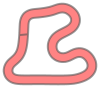

In [77]:
# Visualize the Track and Waypoints

# Tracks Available::
# AWS_track                Straight_track                Oval_track
# Bowtie_track             H_track                       reinvent_base
# China_track              Mexico_track                  Canada_training
# Virtual_May19_Train_Track                              Tokyo_Training_track
# reInvent2019_track

waypoints = get_track_waypoints("China_track")
print("Waypoints shape: {}".format(waypoints.shape))

center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]
l_center_line = LineString(waypoints[:,0:2])
l_inner_border = LineString(waypoints[:,2:4])
l_outer_border = LineString(waypoints[:,4:6])
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))

# Print some useful track analysis data
print("Centerline length: %0.2f" % l_center_line.length)
print("Track bounds: ", road_poly.bounds)
print(waypoints[0])
print("Track width: ", np.linalg.norm(waypoints[0,4:6] - waypoints[0,2:4]))
#print("Track y min/max: ", pd.DataFrame(outer_border)['y'])
road_poly

# Load the training log

In [78]:

# Cloudwatch origin
#fname = 'logs/deepracer-%s.log' % sim_id
#data = load_data(fname)
#df = convert_to_pandas(data, None)


# Local training
df = s3_fluent_logs.extract_simulation(log_path)

df.head(100)

,iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,done,on_track,progress,closest_waypoint,track_len,timestamp,simtime
0,1,0,0,3.0500,0.6833,0.0004,0.00,0.0,0.0,1.000,0,True,0.7922,0,17.67,1574810852.061788,76.887
1,1,0,1,3.0501,0.6832,-0.0003,-0.52,2.0,0.0,1.000,0,True,0.7927,0,17.67,1574810852.315706,77.014
2,1,0,2,3.0525,0.6811,-0.0147,-0.26,2.0,1.0,1.000,0,True,0.8064,0,17.67,1574810852.396268,77.046
3,1,0,3,3.0647,0.6718,-0.0762,-0.52,2.0,0.0,1.000,0,True,0.8751,0,17.67,1574810852.5583315,77.115
4,1,0,4,3.0750,0.6628,-0.1316,0.52,2.0,4.0,1.000,0,True,0.9335,0,17.67,1574810852.6445627,77.157
5,1,0,5,3.0987,0.6427,-0.2399,-0.26,2.0,1.0,1.000,0,True,1.0677,0,17.67,1574810852.7825017,77.226
6,1,0,6,3.1232,0.6216,-0.3332,-0.26,2.0,1.0,0.500,0,True,1.2064,1,17.67,1574810852.90647,77.285
7,1,0,7,3.1490,0.5943,-0.4261,0.00,2.0,2.0,0.500,0,True,1.3523,1,17.67,1574810853.0431988,77.356
8,1,0,8,3.1736,0.5692,-0.5035,-0.26,2.0,1.0,0.500,0,True,1.4915,1,17.67,1574810853.1982925,77.425
9,1,0,9,3.1993,0.5371,-0.5796,0.00,2.0,2.0,0.100,0,True,1.6369,1,17.67,1574810853.3482614,77.496


In [79]:
df_rewards = df[df['reward'] > 0.01]
#df_rewards.head(100)

In [80]:
deltas = df[['simtime']].diff()
not_renice = df[df['iteration'] > 3].copy()
not_renice = not_renice[not_renice['iteration'] < 6].copy()
not_renice = not_renice[not_renice['steps'] > 0]
not_renice['simtimedelta'] = not_renice['simtime'].diff()
not_renice = not_renice.dropna()

not_renice = not_renice[not_renice['simtimedelta'] < 5]
not_renice['simtimedelta'].describe()
#not_renice['simtimedelta'].median()

#not_renice['simtimedelta'].plot.hist(by='simtimedelta', bins=50, figsize=(12,5))

#not_renice = not_renice[not_renice['simtimedelta'] > 0.3]
#not_renice[not_renice['simtimedelta'] > 0.3].head(50)


count    2821.000000
mean        0.072104
std         0.047015
min         0.017000
25%         0.062000
50%         0.067000
75%         0.072000
max         0.610000
Name: simtimedelta, dtype: float64

In [81]:
## Manage the size of data by getting only the last n rows
max_episode_number = np.max(df['episode'])
MAX_EPISODES=5000

print("Shape: \t\t\t", (df.shape, df['episode'].min(), df['episode'].max(), df['iteration'].min(), df['iteration'].max()))
df = df[df['episode'] > (max_episode_number - MAX_EPISODES)]
df = df.reset_index(drop=True)
print("Shape (truncated): \t", (df.shape, df['episode'].min(), df['episode'].max(), df['iteration'].min(), df['iteration'].max()))
print("Car y min/max: \t\t", (df['y'].min(), df['y'].max()))
print("Reward min/max/med/mean: ", (df['reward'].min(), df['reward'].max(), df['reward'].median(), df['reward'].mean()))

Shape: 			 ((124589, 17), 0, 507, 1, 26)
Shape (truncated): 	 ((124589, 17), 0, 507, 1, 26)
Car y min/max: 		 (0.1952, 4.9922)
Reward min/max/med/mean:  (0.0, 1.0, 1.0, 0.8339655266516304)


# Plot the action space coverage

,throttle,degrees,count,mean reward,std,min,25%,50%,75%,max reward
0,0.0,0.000000,508.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
1,2.0,-29.793805,21572.0,0.842468,0.300133,0.0,1.0,1.0,1.0,1.0
2,2.0,-14.896903,15820.0,0.800533,0.331717,0.0,0.5,1.0,1.0,1.0
3,2.0,0.000000,21693.0,0.820420,0.304155,0.0,0.5,1.0,1.0,1.0
4,2.0,14.896903,28342.0,0.838890,0.297792,0.0,0.5,1.0,1.0,1.0
5,2.0,29.793805,36654.0,0.845300,0.285831,0.0,1.0,1.0,1.0,1.0


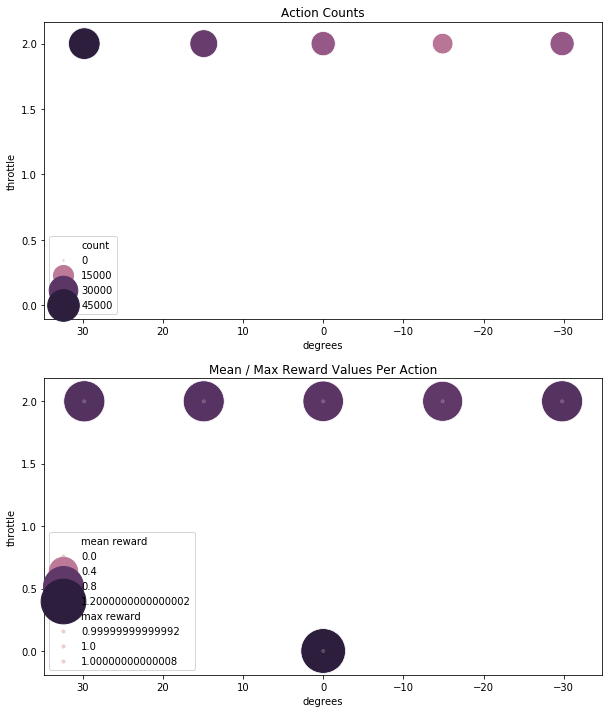

In [82]:
import seaborn as sns

# Reject initial actions where there is no action index
#df_not_empty = df[df['throttle'] != 0.0]
df['degrees'] = df['steer'].transform(lambda x: math.degrees(x))
unique_actions = df.groupby(['throttle','degrees']).size().reset_index(name='count')
#print(df.groupby(['throttle','degrees'])

# Plot how often model used the action choices
fig = plt.figure(figsize=(10,12))
ax = fig.add_subplot(211)
sns.scatterplot(x='degrees', 
                y='throttle', 
                size='count', 
                sizes=(2,1000),
                hue='count', 
                data=unique_actions, 
                ax=ax)
ax.set_title('Action Counts')
ax.set_xlim(df['degrees'].max()+5,df['degrees'].min()-5);

# Plot how much reward was given for action choices
action_rewards = df.groupby(['throttle','degrees']).reward.describe().reset_index().rename(columns={'mean': 'mean reward', 'max': 'max reward'})

ax = fig.add_subplot(212)
sns.scatterplot(x='degrees', 
                y='throttle', 
                size='mean reward',
                sizes=(10,2000), 
                size_norm=(0,action_rewards['max reward'].max()),
                hue='mean reward',
                hue_norm=(0,action_rewards['max reward'].max()),
                legend='brief',
                data=action_rewards, 
                ax=ax)
sns.scatterplot(x='degrees', 
                y='throttle', 
                size='max reward',
                sizes=(10,2000),
                hue='max reward',
                alpha=0.2,
                legend='brief',
                data=action_rewards, 
                ax=ax)
ax.set_title('Mean / Max Reward Values Per Action')
ax.set_xlim(df['degrees'].max()+5,df['degrees'].min()-5);
#unique_actions
action_rewards


## Plot rewards per Iteration

This graph is useful to understand the mean reward and standard deviation within each episode 

In [83]:
# Normalize the rewards to a 0-1 scale

from sklearn.preprocessing import  MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
min_max_scaler = MinMaxScaler()
# Use this for normal scaled factors 0..1
scaled_vals = min_max_scaler.fit_transform(df['reward'].values.reshape(df['reward'].values.shape[0], 1))
# Use this for log-scale rewards
#log_transformer = FunctionTransformer(np.log1p, validate=True)
#scaled_vals = min_max_scaler.fit_transform(log_transformer.transform(df['reward'].values.reshape(df['reward'].values.shape[0], 1)))

df['scaled_reward'] = pd.DataFrame(scaled_vals.squeeze())
(df['scaled_reward'].min(), df['scaled_reward'].max())

(0.0, 1.0)

In [84]:
# Filter out bad episodes due to training rig missing timeslices
#broken_episodes = df['']

Number of episodes =  507


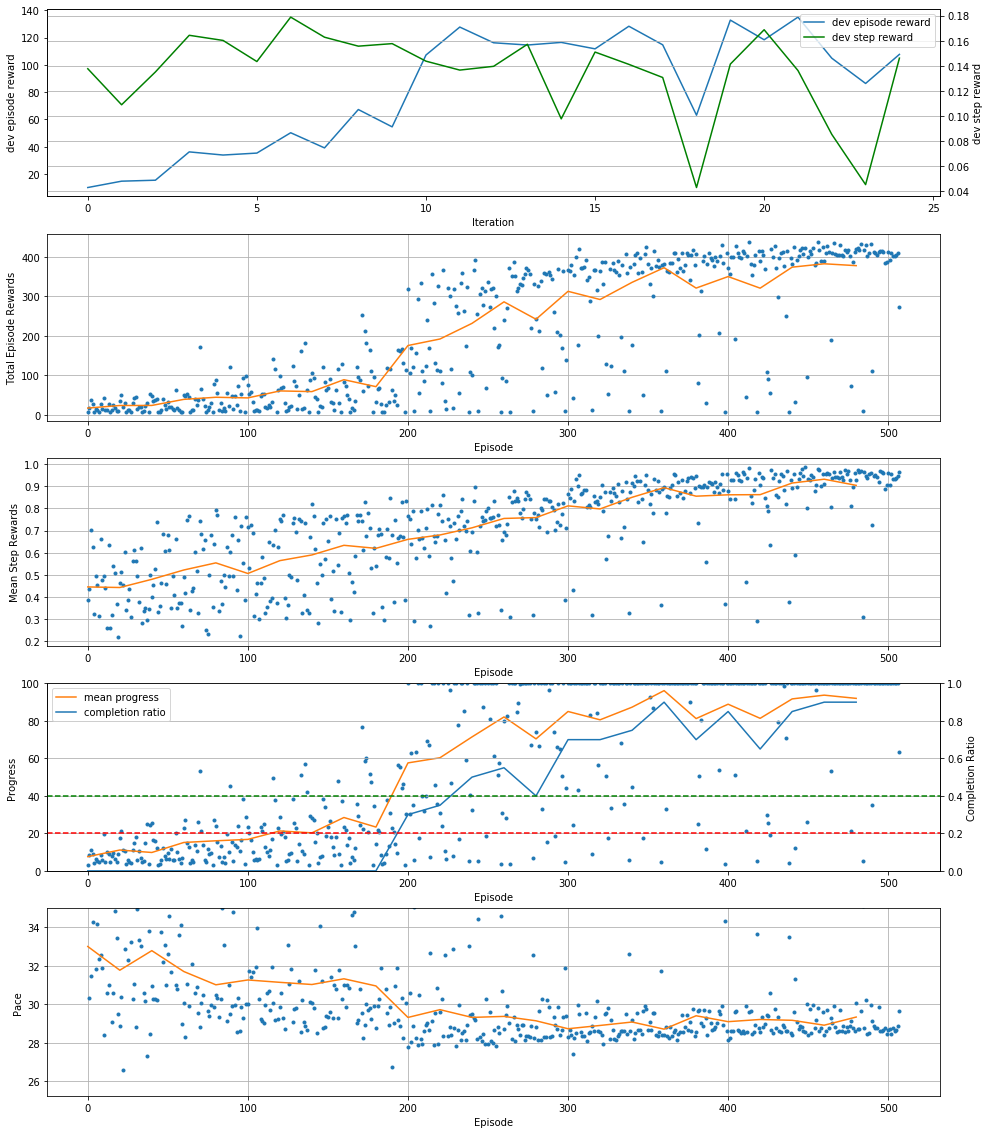

Lower pace should equate to higher rewards


Text(0, 0.5, 'Mean pace per episode')

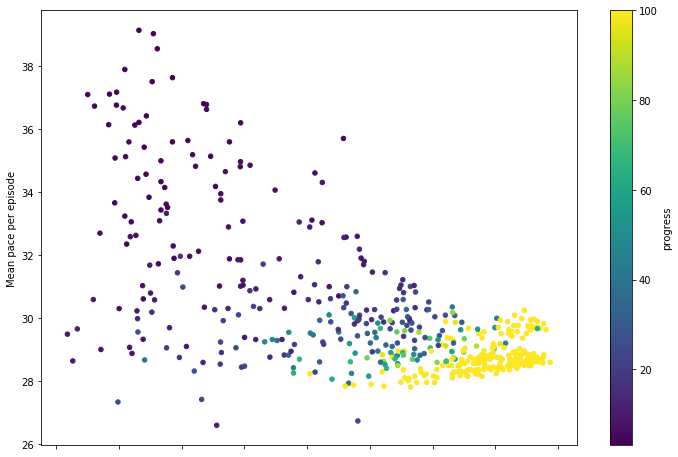

In [85]:
REWARD_THRESHOLD = 800
EPISODES_PER_ITERATION = 20 # TODO: Don't hard-code 20 episodes per iteration

#TIMESTAMP_COLUMN = 'timestamp' # For cloudwatch
#TIMESTAMP_COLUMN = 'tstamp' # For csv logs
TIMESTAMP_COLUMN = 'simtime' # For local training either this or steps
#TIMESTAMP_COLUMN = 'steps'
#df['simtime_from_steps'] = df['steps'] * 1/15
#TIMESTAMP_COLUMN = 'simtime_from_steps'


# reward graph per episode
min_episode = np.min(df['episode'])
max_episode = np.max(df['episode'])
print('Number of episodes = ', max_episode - min_episode)



# Gather per-episode metrics
total_reward_per_episode = list()
total_progress_per_episode = list()
pace_per_episode = list()
# dive into per-step rewards
mean_step_reward_per_episode = list()
min_step_reward_per_episode = list()
max_step_reward_per_episode = list()

for epi in range(min_episode, max_episode+1):
    df_slice = df[df['episode'] == epi]
#    total_reward_per_episode.append(np.sum(df_slice['scaled_reward']))
    total_reward_per_episode.append(np.sum(df_slice['reward']))
    total_progress_per_episode.append(np.max(df_slice['progress']))
    elapsed_time = float(np.max(df_slice[TIMESTAMP_COLUMN])) - float(np.min(df_slice[TIMESTAMP_COLUMN]))
    pace_per_episode.append(elapsed_time * (100 / np.max(df_slice['progress'])))
    mean_step_reward_per_episode.append(np.mean(df_slice['reward']))
    min_step_reward_per_episode.append(np.min(df_slice['reward']))
    max_step_reward_per_episode.append(np.max(df_slice['reward']))

# Generate per-iteration averages
average_reward_per_iteration = list()
deviation_reward_per_iteration = list()
buffer_rew = list()
for val in total_reward_per_episode:
    buffer_rew.append(val)
    if len(buffer_rew) == EPISODES_PER_ITERATION:
        average_reward_per_iteration.append(np.mean(buffer_rew))
        deviation_reward_per_iteration.append(np.std(buffer_rew))
        buffer_rew = list()

average_mean_step_reward_per_iteration = list()
deviation_mean_step_reward_per_iteration = list()
buffer_rew = list()
for val in mean_step_reward_per_episode:
    buffer_rew.append(val)
    if len(buffer_rew) == EPISODES_PER_ITERATION:
        average_mean_step_reward_per_iteration.append(np.mean(buffer_rew))
        deviation_mean_step_reward_per_iteration.append(np.std(buffer_rew))
        buffer_rew = list()

average_pace_per_iteration = list()
buffer_rew = list()
for val in pace_per_episode:
    buffer_rew.append(val)
    if len(buffer_rew) == EPISODES_PER_ITERATION:
        average_pace_per_iteration.append(np.mean(buffer_rew))
        buffer_rew = list()

average_progress_per_iteration = list()
lap_completion_per_iteration = list()
buffer_rew = list()
for val in total_progress_per_episode:
    buffer_rew.append(val)
    if len(buffer_rew) == EPISODES_PER_ITERATION:
        average_progress_per_iteration.append(np.mean(buffer_rew))
        lap_completions = buffer_rew.count(100.0)
        lap_completion_per_iteration.append(lap_completions / EPISODES_PER_ITERATION)
        buffer_rew = list()

        
# Plot the data
fig = plt.figure(figsize=(16, 20))

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD :
        ax.plot(rr, average_reward_per_iteration[rr], 'r.')

ax = fig.add_subplot(511)
line1, = ax.plot(np.arange(len(deviation_reward_per_iteration)), deviation_reward_per_iteration)
ax.set_ylabel('dev episode reward')
ax.set_xlabel('Iteration')
ax = ax.twinx()
line2, = ax.plot(np.arange(len(deviation_mean_step_reward_per_iteration)), deviation_mean_step_reward_per_iteration, color='g')
ax.set_ylabel('dev step reward')
plt.legend((line1, line2), ('dev episode reward', 'dev step reward'))
plt.grid(True)

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD:
        ax.plot(rr, deviation_reward_per_iteration[rr], 'r.')


ax = fig.add_subplot(512)
ax.plot(np.arange(len(total_reward_per_episode)), total_reward_per_episode, '.')
ax.plot(np.arange(0, len(average_reward_per_iteration)*EPISODES_PER_ITERATION, EPISODES_PER_ITERATION), average_reward_per_iteration)
ax.set_ylabel('Total Episode Rewards')
ax.set_xlabel('Episode')
plt.grid(True)

ax = fig.add_subplot(513)
ax.plot(np.arange(len(mean_step_reward_per_episode)), mean_step_reward_per_episode, '.')
ax.plot(np.arange(0, len(average_mean_step_reward_per_iteration)*EPISODES_PER_ITERATION, EPISODES_PER_ITERATION), average_mean_step_reward_per_iteration)
#min_reward_per_episode = list()
#max_reward_per_episode = list()
ax.set_ylabel('Mean Step Rewards')
ax.set_xlabel('Episode')
plt.grid(True)

ax = fig.add_subplot(514)
ax.plot(np.arange(len(total_progress_per_episode)), total_progress_per_episode, '.')
line1, = ax.plot(np.arange(0, len(average_progress_per_iteration)*EPISODES_PER_ITERATION, EPISODES_PER_ITERATION), average_progress_per_iteration)
ax.set_ylabel('Progress')
ax.set_xlabel('Episode')
ax.set_ylim(0,100)
ax = ax.twinx()
ax.set_ylabel('Completion Ratio')
ax.set_ylim(0,1.0)
line2, = ax.plot(np.arange(0, len(lap_completion_per_iteration)*EPISODES_PER_ITERATION, EPISODES_PER_ITERATION), lap_completion_per_iteration)
ax.axhline(0.2, linestyle='--', color='r') # Target minimum 20% completion ratio
ax.axhline(0.4, linestyle='--', color='g') # Completion of 40% should accomodate higher speeds
plt.legend((line1, line2), ('mean progress', 'completion ratio'), loc='upper left')
plt.grid(True)

PACE_STANDARD_DEVIATIONS=4

ax = fig.add_subplot(515)
ax.plot(np.arange(len(pace_per_episode)), pace_per_episode, '.')
ax.plot(np.arange(0, len(average_pace_per_iteration)*EPISODES_PER_ITERATION, EPISODES_PER_ITERATION), average_pace_per_iteration)
ax.set_ylim(np.mean(pace_per_episode) - 2 * np.std(pace_per_episode), np.mean(pace_per_episode) + 2 * np.std(pace_per_episode))
ax.set_ylabel('Pace')
ax.set_xlabel('Episode')
plt.grid(True)

plt.show()

# See if rewards correlate with pace
print("Lower pace should equate to higher rewards")

df_mean_step_reward_per_episode = pd.DataFrame(list(zip(mean_step_reward_per_episode, 
                                                        pace_per_episode,
                                                        total_progress_per_episode)), 
                                               columns=['mean_step_reward','pace', 'progress'])
cropped = df_mean_step_reward_per_episode[abs(df_mean_step_reward_per_episode - np.mean(df_mean_step_reward_per_episode)) < PACE_STANDARD_DEVIATIONS * np.std(df_mean_step_reward_per_episode)]
ax = cropped.plot.scatter('mean_step_reward',
                          'pace', 
                          c='progress', 
                          colormap='viridis', 
                          figsize=(12,8))
ax.set_xlabel('Mean step reward per episode')
ax.set_ylabel('Mean pace per episode')



In [70]:
# Only applicable for training & evaluation.  Submissions use the race track and don't apply here
max_iteration_number = df['iteration'].max()
min_iteration_number = max_iteration_number - 5
df_last_n_iterations = df[df['iteration'] > min_iteration_number]
total_episodes_last_n_iterations = df_last_n_iterations[df_last_n_iterations['done'] == 1].shape[0]
finished_episodes_last_n_iterations = df_last_n_iterations[df_last_n_iterations['progress'] == 100.0]

print("Completion ratio: %.2f" % (finished_episodes_last_n_iterations.shape[0] / float(total_episodes_last_n_iterations)))
print("Training pace (min,mean,max): %0.2f %0.2f %0.2f" % (np.min(pace_per_episode), np.mean(pace_per_episode), np.max(pace_per_episode)))
tr_ratio = 1.0
print("Race pace (min,mean,max): %0.2f %0.2f %0.2f" % (np.min(pace_per_episode) * tr_ratio, np.mean(pace_per_episode) * tr_ratio, np.max(pace_per_episode) * tr_ratio))
fastest_index = pace_per_episode.index(np.min(pace_per_episode))
np.flip(np.argsort(total_reward_per_episode)[-3:])
print("Fastest episode: ", df['episode'].min() + fastest_index)
df_full_laps = df[df['progress'] == 100.0]
full_lap_episode_indexes = df_full_laps['episode'].values
#print("All full laps: ", full_lap_episodes)
paces_for_full_laps = [(i, pace_per_episode[i]) for i in full_lap_episode_indexes]
fastest_full_laps = sorted(paces_for_full_laps, key=lambda x: x[1])
print("Fastest 3 full laps: ", fastest_full_laps[0:3])

farthest_index = df.loc[df['progress'].idxmax()].episode
#farthest_three = df['progress'].argsort()[-3:]
#print("Farthest 3: ", farthest_three)
print("Farthest lap: ", farthest_index)
best_index = total_reward_per_episode.index(np.max(total_reward_per_episode))
print("Highest reward lap: ", df['episode'].min() + best_index)

# TODO: This should be shifted based on the actual episode number, not just the index of the array
print("Highest 3 reward lap INDEXES: ", np.flip(np.argsort(total_reward_per_episode)[-3:]))
#print("Progress (min,mean,max): %0.2f %0.2f %0.2f" % (finished_episodes_last_n_iterations.min(),
#                                                      finished_episodes_last_n_iterations.mean(),
#                                                      finished_episodes_last_n_iterations.max()))

if fastest_full_laps[0][0] != best_index:
    # The fastest full lap should always be the most rewarded, unless its early in training
    # and all full laps are lucky and windy.
    print("************************************************")
    print("WARNING: FASTEST FULL LAP IS NOT MOST REWARDED!!")
    print("************************************************")


Completion ratio: 0.85
Training pace (min,mean,max): 50.97 58.82 85.82
Race pace (min,mean,max): 50.97 58.82 85.82
Fastest episode:  22
Fastest 3 full laps:  [(528, 53.96900000000096), (189, 54.906000000000404), (249, 55.11700000000019)]
Farthest lap:  189
Highest reward lap:  531
Highest 3 reward lap INDEXES:  [531 505 496]
************************************************
************************************************


In [290]:
finished_episodes = df[df['done'] == 1]
thirty_percent_episodes = finished_episodes[finished_episodes['progress'] >= 30]
window = thirty_percent_episodes[thirty_percent_episodes['progress'] <= 32]
window.shape
window.head(10)
# episodes
# 335
# 337
# 367
# 378
# 417
episode = 335
print(total_reward_per_episode[episode], pace_per_episode[episode], total_progress_per_episode[episode], df[df['episode'] == episode]['steps'].max())
episode = 367
print(total_reward_per_episode[episode], pace_per_episode[episode], total_progress_per_episode[episode], df[df['episode'] == episode]['steps'].max())
episode = 378
print(total_reward_per_episode[episode], pace_per_episode[episode], total_progress_per_episode[episode], df[df['episode'] == episode]['steps'].max())
episode = 417
print(total_reward_per_episode[episode], pace_per_episode[episode], total_progress_per_episode[episode], df[df['episode'] == episode]['steps'].max())

IndexError: list index out of range

In [ ]:
# Sandbox for twitch front-end
fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(111)
# Show only most recent 20 data points
progress_data = average_progress_per_iteration[-21:-1]
ax.plot(progress_data, linewidth=5)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax = ax.twinx()
pace_data = average_pace_per_iteration[-21:-1]
ax.plot(pace_data, color='red', linewidth=5)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax = ax.twinx()
reward_data = average_reward_per_iteration[-21:-1]
ax.plot(reward_data, color='green', linewidth=5)
ax.set_yticklabels([])
ax.set_xticklabels([])

## Analyze the reward distribution for your reward function

In [ ]:
df['reward'].plot.hist(by='reward', bins=50, range=(0.02,2.0), title='Reward Distribution for Training Session', figsize=(12,5))
print("Episode Rewards (min,mean,max): %.2f %.2f %.2f" % (np.min(total_reward_per_episode), np.mean(total_reward_per_episode), np.max(total_reward_per_episode)))
print("Step Rewards (min,mean,max): %.2f %.2f %.2f" % (df['reward'].min(), df['reward'].mean(), df['reward'].max()))
print("Verify that there is a good spread of over the training, leading to strong guidance for the model")
print("For a well-trained model for speed, it should skew toward the higher values, not a normal distribution")

NEAR = 67

df_checkpoint_reward = df[abs(df['progress'] - NEAR) < 2.0]
df_checkpoint_reward = df_checkpoint_reward[df_checkpoint_reward['reward'] > 0.1]
plt.show()
df_checkpoint_reward['reward'].plot.hist(by='reward', bins=50, range=(0.02,1.0), title='Reward Distribution for Checkpoint Near %d' % NEAR, figsize=(12,5))

In [30]:
#df['reward'].plot.hist(by='reward', bins=200, range=(0.63,0.65), title='Reward Distribution for Training Session', figsize=(12,5))
df_odd_rewards = df[df['reward'] > 0.63]
df_odd_rewards = df_odd_rewards[df_odd_rewards['reward'] < 0.65]
df_odd_rewards.head(50)

,iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,done,on_track,progress,closest_waypoint,track_len,timestamp,simtime,degrees,scaled_reward
77,1,0,77,6.8557,6.4967,2.4879,0.35,7.0,0.0,0.6336,0,True,62.5529,97,23.12,1573746675.3130426,46.808,20.053523,0.081451
90,1,1,7,0.3994,2.4046,-1.3112,0.35,7.0,0.0,0.6426,0,True,1.8870,3,23.12,1573746678.1636674,48.207,20.053523,0.082608
212,1,4,7,0.4075,2.3934,-1.2828,0.35,7.0,0.0,0.6319,0,True,1.9410,3,23.12,1573746697.1045785,57.603,20.053523,0.081233
421,1,7,7,0.4183,2.3796,-1.2708,0.22,10.0,1.0,0.6355,0,True,2.0161,3,23.12,1573746727.609662,72.640,12.605071,0.081695
613,1,11,75,7.2259,6.4442,2.4667,0.35,7.0,0.0,0.6464,0,True,61.0645,94,23.12,1573746756.9937642,87.035,20.053523,0.083097
707,1,14,7,0.4308,2.3882,-1.2184,0.22,10.0,1.0,0.6315,0,True,1.9919,3,23.12,1573746772.1106105,94.499,12.605071,0.081181
806,1,16,8,0.4406,2.2505,-1.2639,0.35,7.0,0.0,0.6494,0,True,2.5817,4,23.12,1573746787.0818136,101.886,20.053523,0.083482
907,1,17,75,7.4695,6.7312,2.1222,0.35,7.0,0.0,0.6314,0,False,60.3559,93,23.12,1573746801.4687762,108.964,20.053523,0.081168
1291,2,29,7,0.4161,2.3680,-1.2798,0.35,7.0,0.0,0.6490,0,True,2.0630,3,23.12,1573746880.3814607,147.773,20.053523,0.083431
1480,2,34,7,0.4132,2.3686,-1.2725,0.35,7.0,0.0,0.6402,0,True,2.0573,3,23.12,1573746909.942181,162.373,20.053523,0.082300


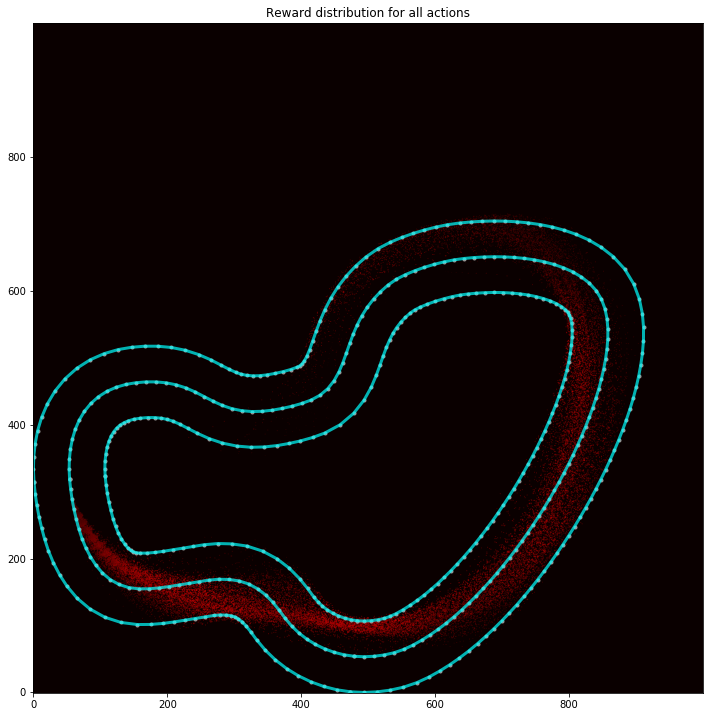

In [31]:
def plot_track(df, center_line, inner_border, outer_border, track_size=(5, 9), x_offset=0, y_offset=0):
    '''
    Each track may have a diff track size, 
    For reinvent track, use track_size=(500, 800)
    Tokyo, track_size=(700, 1000)
    x_offset, y_offset is used to convert to the 0,0 coordinate system
    '''
    track = np.zeros((track_size[0] * 100, track_size[1] * 100))
    outer_df = pd.DataFrame(outer_border, columns=('x','y'))
    translate_y = -min(df['y'].min(), outer_df['y'].min())
    translate_x = -min(df['x'].min(), outer_df['x'].min())
    #print("Applying translation ", (translate_x, translate_y))
    for index, row in df.iterrows():
        x = int((row["x"] + translate_x) * 100)
        y = int((row["y"] + translate_y) * 100)
        # Use this line for log-scale rewards
        #reward = log(row["reward"]) if row["reward"] > 0 else 0
        #reward = row["reward"] if row["reward"] > 0 else 0
        reward = row["scaled_reward"] if row["scaled_reward"] > 0 else 0
        
        track[y,x] = reward
        
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(111, facecolor='black')
    t_center = np.empty(shape=(len(center_line),2))
    t_outer = np.empty(shape=(len(outer_border),2))
    t_inner = np.empty(shape=(len(inner_border),2))
    for i in range(len(center_line)):
        t_center[i] = ((center_line[i][0] + translate_x, center_line[i][1] + translate_y))
        t_outer[i] = ((outer_border[i][0] + translate_x, outer_border[i][1] + translate_y))
        t_inner[i] = ((inner_border[i][0] + translate_x, inner_border[i][1] + translate_y))
        
    print_border(ax, t_center * 100, t_inner * 100, t_outer * 100)
    return track

track = plot_track(df, center_line, inner_border, outer_border, track_size=(10, 10))
plt.title("Reward distribution for all actions")

im = plt.imshow(track, aspect='equal', cmap='hot', interpolation='bilinear', origin="lower")


# Plot the exit points

Look for:
 a) Many different colors in one spot means car has trouble navigating in that area
    regardless of start position and speed
 b) Many same colors in one spot means the car had trouble with particular starting position
    which can be disregarded if correlating to middle-of-track starts during training, but should 
    be looked at if the start position was the actual track zero waypoint


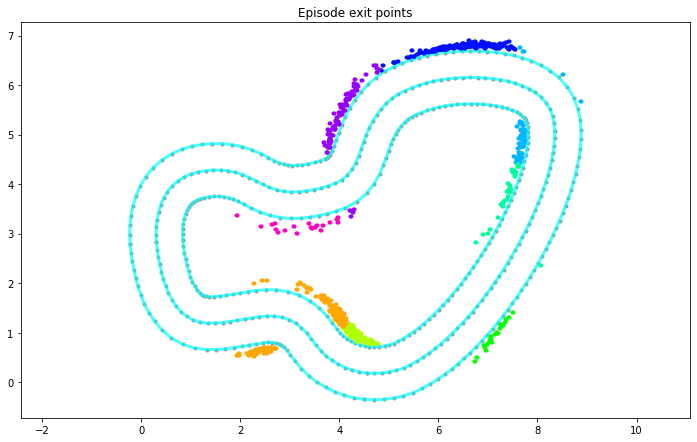

In [32]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
exits_df = df[df['done'] == 1]
fig = plt.figure(1, figsize=(12, 16))
ax = fig.add_subplot(211)
print_border(ax, center_line, inner_border, outer_border)
plt.title("Episode exit points") # only the off-track exits where done=1
ax.axis('equal')

# Darker, more opaque means the car was closer to 100% progress
cmap = cm.get_cmap('hsv', 10)
for row in exits_df.iterrows():
    x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
    car_x2, car_y2 = x1 - 0.02, y1
    progress = row[1]['progress'] # color the point based on how far it went
    plt.plot([x1, car_x2], [y1, car_y2], c=cmap(progress/100), marker='.')
    
print("Look for:")
print(" a) Many different colors in one spot means car has trouble navigating in that area")
print("    regardless of start position and speed")
print(" b) Many same colors in one spot means the car had trouble with particular starting position")
print("    which can be disregarded if correlating to middle-of-track starts during training, but should ")
print("    be looked at if the start position was the actual track zero waypoint")

## Plot the actions taken across the track

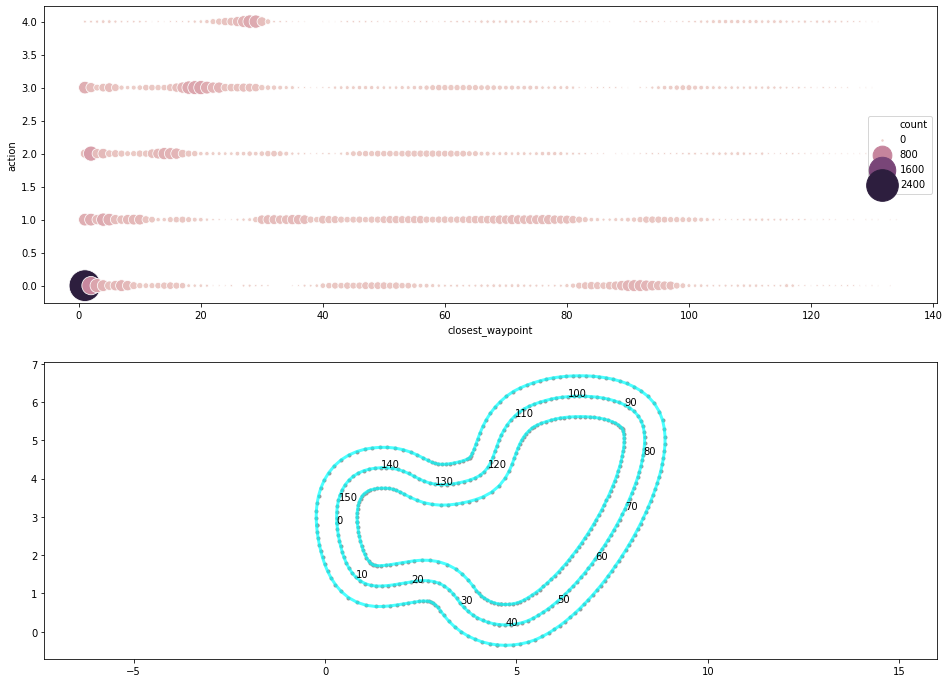

In [33]:
# Plot how often model used the action choices

actions_per_waypoint = df.groupby(['closest_waypoint','action']).size().reset_index(name='count')
actions_per_waypoint.head()
#actions_per_waypoint.plot.scatter()
#actions_per_waypoint['closest_waypoint','action','timestamp'] #.plot.bar()
actions_per_waypont = actions_per_waypoint[actions_per_waypoint['closest_waypoint'] % 5 == 0]
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(211)
sns.scatterplot(x='closest_waypoint', 
                y='action', 
                size='count', 
                sizes=(2,1000),
                hue='count', 
                data=actions_per_waypoint, 
                ax=ax)
#ax.set_title('Action Counts')
#ax.set_xlim(df['degrees'].max()+5,df['degrees'].min()-5);
ax = fig.add_subplot(212)
ax.axis('equal')
print_border(ax, center_line, inner_border, outer_border)

for i in range(0,len(center_line),10):
    point = center_line[i]
    point_xy = (point[0], point[1])
    plt.annotate('%d' % i, point_xy)

# Path taken in a particular episode

In [34]:
## Evaluation RUN
def plot_episode_run(df, E):
    fig = plt.figure(1, figsize=(18, 64))
    ax = fig.add_subplot(611)
    ax.axis('equal')
    print_border(ax, center_line, inner_border, outer_border)
    episode_data = df[df['episode'] == E].copy().sort_values(['steps'])
    for i,row in episode_data.iterrows():
        x1,y1,action,reward = row['x'], row['y'], row['action'], row['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.quiver(x1, y1, math.cos(row['yaw']), math.sin(row['yaw']), scale=100)
        plt.quiver(x1, y1, math.cos(row['yaw'] + row['steer']), math.sin(row['yaw'] + row['steer']), scale=100, color='red')
        if row['steps'] % 5 == 0:
            plt.annotate('%d' % row['steps'], (x1,y1))
    first_point = episode_data.iloc[0]
    start_xy = (first_point['x'], first_point['y'])
    plt.annotate('Start', start_xy)
    elapsed_time = float(np.max(episode_data[TIMESTAMP_COLUMN])) - float(np.min(episode_data[TIMESTAMP_COLUMN]))
    pace = elapsed_time * (100 / np.max(episode_data['progress']))
    ax.text(0.2, 0.3, 'Pace: %0.2f' % pace,
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=32,
        bbox=dict(facecolor='red', alpha=0.5))
    ax.text(0.2, 0.2, 'Episode: %d' % E,
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=16,
        bbox=dict(facecolor='red', alpha=0.5))
    ax.text(0.2, 0.12, 'Steps: %d' % episode_data['steps'].max(),
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=16,
        bbox=dict(facecolor='red', alpha=0.5))
    ax.text(0.2, 0.12, 'Steps: %d' % episode_data['steps'].max(),
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=16,
        bbox=dict(facecolor='red', alpha=0.5))

    # Plot the speed over the track
    # Look for:
    #   - severe steering having effect on speed (is the car slowing down?)
    #   - throttle effect on speed (Is the car accelerating/decelerating as expected?)
    ax = fig.add_subplot(612)
    speed_data = episode_data[['x','y','progress']].diff().dropna()
    step_timeslice = 1/15 # VERY presumptuous. measured variance of this can be up to 33ms off
    episode_data['speed'] = speed_data.apply(lambda row: math.sqrt(row['x']**2 + row['y']**2)/(1/15), axis=1)
    episode_data['cog'] = speed_data.apply(lambda row: np.angle(complex(row['x'],row['y'])), axis=1)
    episode_data['throttle_corrected'] = episode_data['throttle'] / 9.54
    episode_data['steering_severity'] = episode_data['steer'].abs()
    episode_data['incremental_progress'] = speed_data['progress']
    #print(episode_data[['steps','speed','throttle','steer','timestamp']].tail(40))
    episode_data.plot(x='steps', y='speed', ax=ax)
    ax = ax.twinx()
    episode_data.plot(x='steps', y='throttle', ax=ax, color='orange')
    ax = ax.twinx()
    episode_data.plot(x='steps', y='steering_severity', ax=ax, color='c')
    plt.grid(True)    
    plt.xlabel('Steps')
    #plt.legend((line1, line2, line3), ('speed', 'throttle','steering severity'), loc='upper right')
    plt.title("Steering and Throttle Effect on Speed")
    
    # Plot the steering and heading correlation
    # Look for:
    #   - are the steering angles great enough to affect heading w.r.t. track curves? (change angles)
    #   - is the car indecisive about steering along any portion of the track? (reduce choices or reward more clearly)
    ax = fig.add_subplot(613)
    heading_data = episode_data[['yaw','steer']].dropna()
    #print(heading_data.head(20))
    episode_data['steer_heading'] = heading_data.apply(lambda row: (row['yaw'] + row['steer']), axis=1)
    episode_data['heading_gradient'] = np.gradient(episode_data['yaw'])
    #print(episode_data[['yaw','steer','steer_heading']].head(20))
    episode_data.plot(x='steps', y=['yaw','steer_heading'], ax=ax)
    plt.title("Steering Effect on Heading")
    plt.grid(True)    


    # Plot the severity of change in heading
    # Look for:
    #   - at mins/maxes there may be a loss of friction and a skid
    ax = fig.add_subplot(614)    
    episode_data.plot(x='steps', y=['steer','heading_gradient'], ax=ax)
    plt.ylim((-0.5,0.5))
    plt.title("Steering Effect on Heading: Severity")
    plt.grid(True)    

    ax = fig.add_subplot(615)
    episode_data.plot(x='steps', y='reward', ax=ax)
    ax.twinx()
    episode_data.plot(x='steps', y='incremental_progress', ax=ax)
    plt.title("Reward and Progress per Step")
    plt.grid(True)    

    # Detect slippage
    # TODO: clamp values when 
    ax = fig.add_subplot(616)
    plt.title("Slippage")
    episode_data['slippage'] = episode_data['yaw'] - episode_data['cog']
    episode_data.plot(x='steps', y=['slippage'], ax=ax)
    plt.ylim((-0.5,0.5)) # roughly 60deg
    plt.grid(True)    

    print("Speed (min/mean/max)", episode_data['speed'].min(), episode_data['speed'].mean(), episode_data['speed'].max())
    print("Steps: ", episode_data['steps'].max())

Speed (min/mean/max) 0.03014962686335935 2.6451738878108424 4.415714919466605
Steps:  112


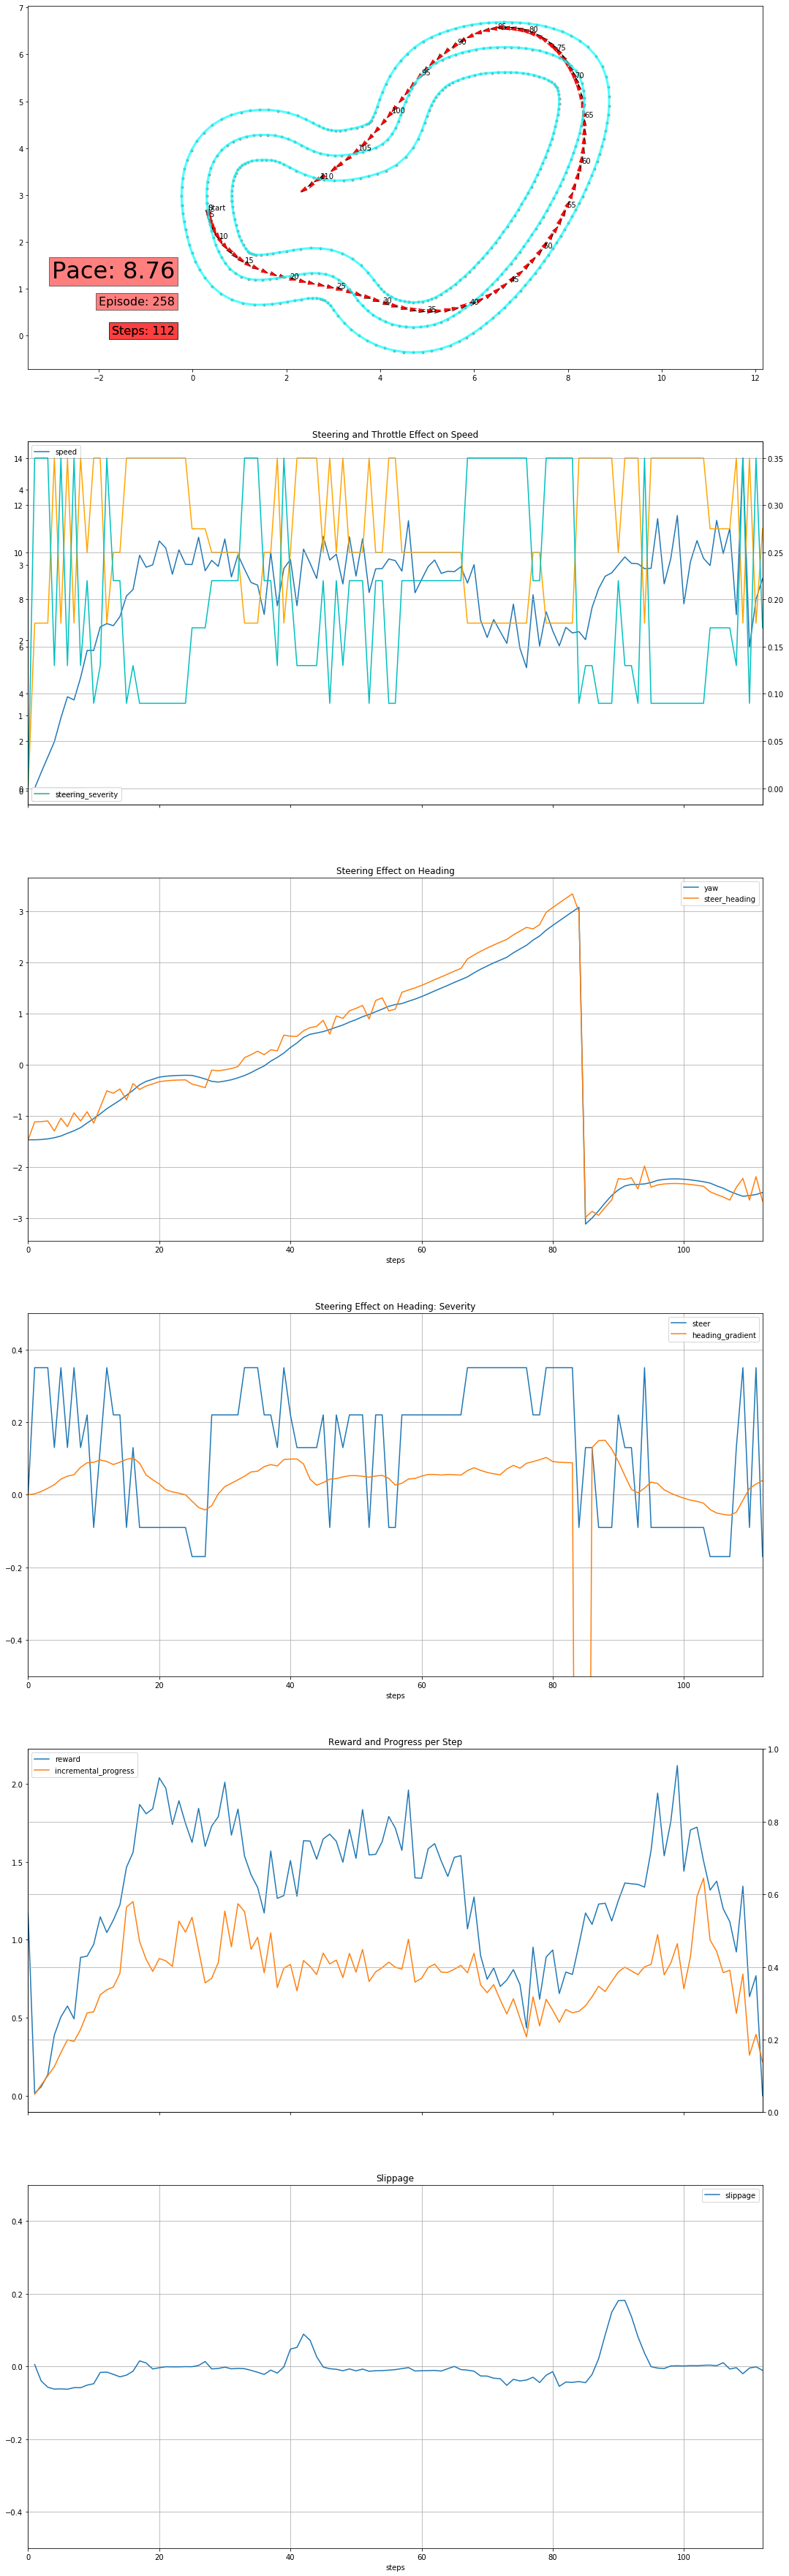

In [37]:
episode = 258 #675
plot_episode_run(df, E=episode) # arbitrary episode

# Model Training Analysis

Load logs of model training and visualize progress

In [124]:
#dr_sm_id = 'deepracer-20190829230539-D59E6A23-366D-48B1-B661-58E83059657E'
#stream_name = 'deepracer-20190829230539-D59E6A23-366D-48B1-B661-58E83059657E/algo-1-1567134475'
#fname = 'logs/deepracer-%s.log' % dr_sm_id
#log_group = '/aws/sagemaker/TrainingJobs'
#cw_utils.download_log(fname, log_group=log_group, stream_prefix=stream_name)

import s3_models
#import importlib
#importlib.reload(s3_models)

In [125]:
# Find available Tensorflow pb models

s3_bucket='aws-deepracer-b6c3c104-eef5-4878-a257-d981cd204d62'

# tiberius session3a
#job_id='20191114030939-14ad716e-bcad-465c-87b1-117a2e718f88'

# Claudius is A/B test for image perturbations
# claudius no-mods
#job_id='20191110045154-91e80226-86b5-41fc-8ea2-37bdc070dfcd'
# claudius with-mods
#job_id='20191112050205-8f08b43c-93c6-40df-8ab5-e7ff43813080'

# nero session1
#job_id='20191121194910-d7442c81-7966-4ed3-bf23-22d93fcfbed3'
# nero session1a
#job_id='20191122140743-8e69f32d-3ed4-4ef9-ab78-1c338bcdb59f'
# nero session1b
#job_id='20191124123204-f86d7945-d893-43fe-ae92-9be63442f736'
# nero session1c (shallow network with OOM issues)
#job_id='20191124225016-bdc2909c-e270-47e2-84d3-97084b68ef12'
# nero session1d
#job_id='20191125220919-8e5a9da1-9d2d-410f-8c51-fd19bf7d75d6'

# galba session1
#job_id='20191128021150-74c993f8-98d8-46d0-be59-e6736942d664'
# galba session2
#job_id='20191128052645-ff18cb68-cbcd-4448-8ac0-41513cbfba73'
# galba session3
job_id='20191207171918-44d0924f-f9d6-464e-b74f-32944de8344c'


s3_prefix='training-jobs/%s/shared/model' % job_id
log_path='models/%s' % job_id
print("Available checkpoints to load")
s3_models.list_available_checkpoints(s3_bucket, s3_prefix, log_path)


Available checkpoints to load


['model_0.pb',
 'model_1.pb',
 'model_2.pb',
 'model_3.pb',
 'model_4.pb',
 'model_5.pb',
 'model_6.pb',
 'model_7.pb',
 'model_8.pb',
 'model_9.pb']

In [127]:
model_path = s3_models.download_checkpoint(s3_bucket, s3_prefix, "model_9.pb", log_path)
actions_path = s3_models.download_actions(s3_bucket, s3_prefix, log_path)
(model_path, actions_path)

import json
with open(actions_path, "r") as f:
    action_space = json.load(f)

# Find the number of actions in the model's action space, needed for loading the network
number_of_actions = len(action_space['action_space'])
number_of_actions, model_path

(5, 'models/20191207171918-44d0924f-f9d6-464e-b74f-32944de8344c/model_9.pb')

## Simulation Image Analysis - Probability distribution on decisions (actions)

is the model making decisions that are "too close" or is it confident for the laps it finishes. if the top and second best decisions are far apart, the model must likely be making more confident decisions 

In [128]:
import tensorflow as tf
import numpy as np
from tensorflow.python.platform import gfile
from PIL import Image

def load_session(pb_path):
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, 
                                    log_device_placement=True))
    print("load graph:", pb_path)
    with gfile.FastGFile(pb_path,'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    graph_nodes=[n for n in graph_def.node]
    names = []
    for t in graph_nodes:
        names.append(t.name)

    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/observation/observation:0')
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    
    return sess, x, y

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [129]:
# Load the model into tensorflow
try:
    model.close()
    tf.reset_default_graph()
except NameError as e:
    pass
model, obs, model_out = load_session(model_path)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



W1207 18:57:45.753896 4566001088 deprecation.py:323] From <ipython-input-128-5b2e5da9985f>:10: FastGFile.__init__ (from tensorflow.python.platform.gfile) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.gfile.GFile.


load graph: models/20191207171918-44d0924f-f9d6-464e-b74f-32944de8344c/model_9.pb


In [130]:
for op in tf.get_default_graph().get_operations():
    print(str(op.name))

main_level/agent/main/online/network_0/observation/observation
main_level/agent/main/online/network_1/observation/truediv/y
main_level/agent/main/online/network_1/observation/truediv
main_level/agent/main/online/network_1/observation/sub/y
main_level/agent/main/online/network_1/observation/sub
main_level/agent/main/online/network_1/observation/Conv2d_0/kernel
main_level/agent/main/online/network_1/observation/Conv2d_0/kernel/read
main_level/agent/main/online/network_1/observation/Conv2d_0/bias
main_level/agent/main/online/network_1/observation/Conv2d_0/bias/read
main_level/agent/main/online/network_1/observation/Conv2d_0/Conv2D
main_level/agent/main/online/network_1/observation/Conv2d_0/BiasAdd
main_level/agent/main/online/network_1/observation/BatchnormActivationDropout_1_activation
main_level/agent/main/online/network_1/observation/Conv2d_2/kernel
main_level/agent/main/online/network_1/observation/Conv2d_2/kernel/read
main_level/agent/main/online/network_1/observation/Conv2d_2/bias
m

In [131]:
# Show available image files
import glob
image_path = 'images'
image_files = sorted(glob.glob(image_path + '/*.png'))
#image_files

In [132]:
import cv2
import numpy as np
import tensorflow as tf

OBSERVATION_SIZE=(160,120) # normal 
#OBSERVATION_SIZE=(84,84) # shallow network

def image_to_npy(image_path):
    img = Image.open(image_path)
    img = img.resize(OBSERVATION_SIZE)

    img_arr = np.array(img)
    img_arr = rgb2gray(img_arr)
    img_arr = np.expand_dims(img_arr, axis=2)
    return img_arr

def analyze_image(image_path):
    img_arr = image_to_npy(image_path)
    current_state = {"observation": img_arr} #(1, 120, 160, 1)
    y_output = model.run(model_out, feed_dict={obs:[img_arr]})[0]
    return y_output

def grey_image(image_path):
    image = Image.open(image_path)    
    grey_img = image.convert('L')
    return grey_img
    
def visualize_gradcam_discrete_ppo(sess, image_path, category_index=0, num_of_actions=6):
    '''
    @inp: model session, RGB Image - np array, action_index, total number of actions 
    @return: overlayed heatmap
    '''
    img_arr = image_to_npy(image_path)
    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/observation/observation:0')
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    feed_dict = {x:[img_arr]}

    #Get he policy head for clipped ppo in coach
    model_out_layer = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    loss = tf.multiply(model_out_layer, tf.one_hot([category_index], num_of_actions))
    reduced_loss = tf.reduce_sum(loss[0])
    conv_output = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/observation/Conv2d_4/Conv2D:0')
    grads = tf.gradients(reduced_loss, conv_output)[0]
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.sum(weights * output, axis=3)

    ##im_h, im_w = 120, 160##
    rgb_img = np.array(Image.open(image_path))
    im_h, im_w = rgb_img.shape[:2]

    cam = cams[0] #img 0
    image = np.uint8(rgb_img[:, :, ::-1] * 255.0) # RGB -> BGR
    cam = cv2.resize(cam, (im_w, im_h)) # zoom heatmap
    cam = np.maximum(cam, 0) # relu clip
    heatmap = cam / np.max(cam) # normalize
    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET) # grayscale to color
    cam = np.float32(cam) + np.float32(image) # overlay heatmap
    cam = 255 * cam / (np.max(cam) + 1E-5) ##  Add expsilon for stability
    cam = np.uint8(cam)[:, :, ::-1] # to RGB

    return cam

# Optionally plot the probabilities as a seaborn 2d grid for speed-steer
def plot_action_probabilities(model_metadata, probabilities):
    # @model_metadata should be the parsed json of model_metadata.json
    # @probabilities should be a list of probabilities output from analyze_image
    df_actions = pd.DataFrame(model_metadata['action_space'])
    fig = plt.figure(figsize=(10,12))
    ax = fig.add_subplot(211)
    sns.scatterplot(x='steering_angle',
                    y='speed', 
                    size=result,
                    sizes=(100,1000),
                    hue=result, 
                    data=df_actions,
                    ax=ax)
    ax.set_title('Action Probabilities')
    ax.set_xlim(df_actions['steering_angle'].max()+5,df_actions['steering_angle'].min()-5);

[2.2663509e-13 1.2216309e-12 3.8388037e-04 9.9961615e-01 1.0967179e-09]


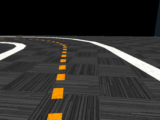

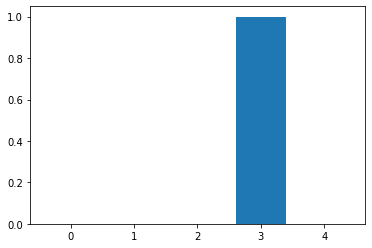

In [133]:
# NOTE: The reinvent2018_carpet is a great use case for intentional overfitting in
#       order to validate the network architecture, as suggested by andrej karpathy.
#       If should have Surrogate Loss and Entropy tend towards zero/NaN and the
#       probabilities in the analyze_image should be very close to 1, the estimated reward
#
#  From http://karpathy.github.io/2019/04/25/recipe/
#
#    The approach I like to take to finding a good model has two stages: first get a 
#    model large enough that it can overfit (i.e. focus on training loss) and then regularize 
#    it appropriately (give up some training loss to improve the validation loss). The reason 
#    I like these two stages is that if we are not able to reach a low error rate with any 
#    model at all that may again indicate some issues, bugs, or misconfiguration.
#

#image_file = 'images/kitchen/5.png'
image_file = 'images/reinvent2018_carpet/127.png'
#image_file = 'images/reinvent2018_carpet/1375.png'
result = analyze_image(image_file)
print(result)
plt.bar(range(number_of_actions), result)
Image.open(image_file)

Straight:  [9.8003019e-09 1.2795079e-03 8.9543766e-01 1.0328277e-01 3.2130519e-08]


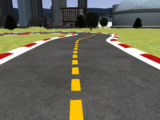

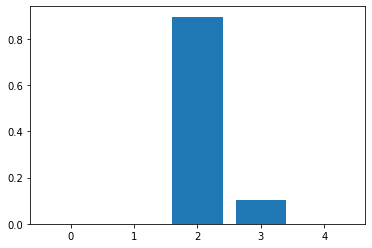

In [997]:
# Specific to captures of Canada Training track
image_file = 'images/canada_training/1680.png' # straight
result = analyze_image(image_file)
print("Straight: ", result)
plt.bar(range(number_of_actions), result)
Image.open(image_file)

Turn:  [0.247634   0.04666341 0.12633592 0.5732801  0.00608658]


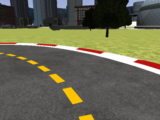

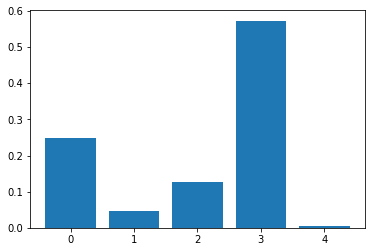

In [998]:
image_file = 'images/canada_training/174.png' # middle of turn
result = analyze_image(image_file)
print("Turn: ", result)
plt.bar(range(number_of_actions), result)
Image.open(image_file)

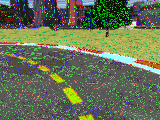

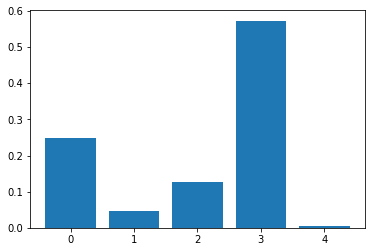

In [999]:
# Scratch pad for image perturbation
import numpy.random as npr
image = Image.open(image_file)
# Perturb the image as somewhat described in https://arxiv.org/abs/1911.01562
r,g,b = image.split()
# Randomize hsv values
r = r.point(lambda i: npr.choice((i,npr.randint(255)), p=(0.8,0.2)))
g = g.point(lambda i: npr.choice((i,npr.randint(255)), p=(0.8,0.2)))
b = b.point(lambda i: npr.choice((i,npr.randint(255)), p=(0.8,0.2)))
image = Image.merge('RGB', (r,g,b))
result = analyze_image(image_file)
plt.bar(range(number_of_actions), result)
image

Exiting:  [4.9772047e-02 2.9886676e-02 9.0443379e-01 2.7548245e-04 1.5632050e-02]


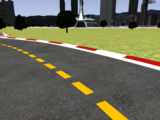

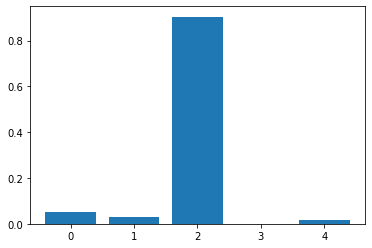

In [1000]:
image_file = 'images/canada_training/290.png' # exiting turn
result = analyze_image(image_file)
print("Exiting: ", result)
plt.bar(range(number_of_actions), result)
Image.open(image_file)

Exited:  [0.03527583 0.05999272 0.5036955  0.13270469 0.26833135]


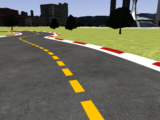

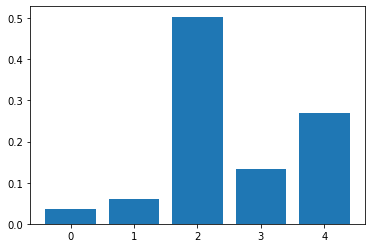

In [1001]:
image_file = 'images/canada_training/330.png' # exiting turn
result = analyze_image(image_file)
print("Exited: ", result)
plt.bar(range(number_of_actions), result)
Image.open(image_file)

Serpentine 1:  [1.2917865e-05 9.9105144e-01 1.8979213e-07 5.7427950e-08 8.9355279e-03]


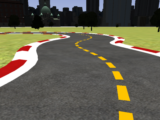

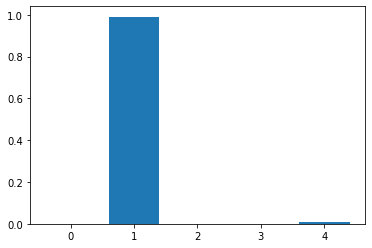

In [1002]:
image_file = 'images/canada_training/845.png' # exiting turn
result = analyze_image(image_file)
print("Serpentine 1: ", result)
plt.bar(range(number_of_actions), result)
Image.open(image_file)

Serpentine 2:  [2.06466691e-04 5.47513890e-04 5.08215010e-01 4.79658425e-01
 1.13725625e-02]


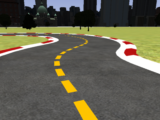

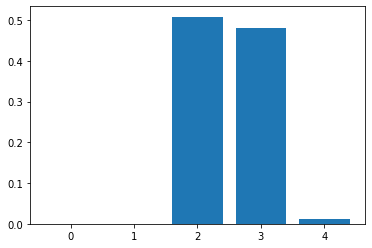

In [1455]:
image_file = 'images/canada_training/890.png' # exiting turn
result = analyze_image(image_file)
print("Serpentine 2: ", result)
plt.bar(range(number_of_actions), result)
Image.open(image_file)

Dog leg right 1:  [0.00058937 0.03585796 0.21009167 0.529616   0.22384493]


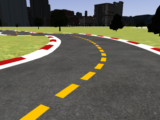

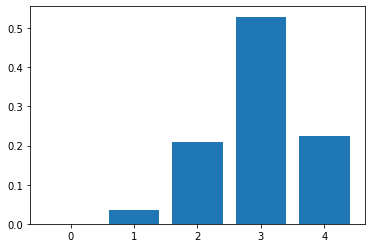

In [1004]:
image_file = 'images/canada_training/497.png' # exiting turn
result = analyze_image(image_file)
print("Dog leg right 1: ", result)
plt.bar(range(number_of_actions), result)
Image.open(image_file)

Dog leg right 2:  [8.0179667e-08 8.6815817e-07 9.9956626e-01 3.8148122e-04 5.1304542e-05]


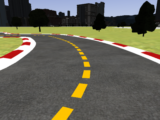

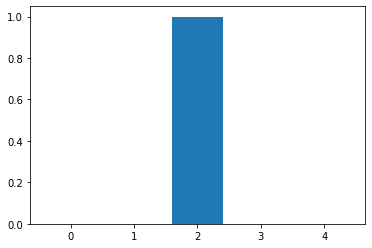

In [1438]:
image_file = 'images/canada_training/513.png' # exiting turn
result = analyze_image(image_file)
print("Dog leg right 2: ", result)
plt.bar(range(number_of_actions), result)
Image.open(image_file)

Dog leg right 2:  [4.8844136e-08 8.5312349e-06 3.0465841e-05 9.9994600e-01 1.4848729e-05]


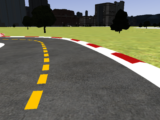

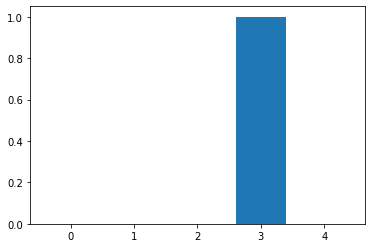

In [1439]:
image_file = 'images/canada_training/591.png' # exiting turn
result = analyze_image(image_file)
print("Dog leg right 2: ", result)
plt.bar(range(number_of_actions), result)
Image.open(image_file)

Dog leg right 3:  [0.0170382  0.00433626 0.95963764 0.00638173 0.01260628]


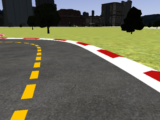

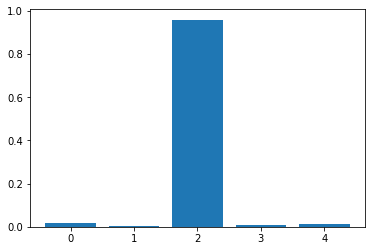

In [1440]:
image_file = 'images/canada_training/621.png' # exiting turn
result = analyze_image(image_file)
print("Dog leg right 3: ", result)
plt.bar(range(number_of_actions), result)
Image.open(image_file)

Dog leg right 3:  [0.03901519 0.14699163 0.61657906 0.07421108 0.12320302]


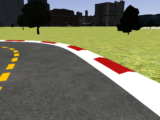

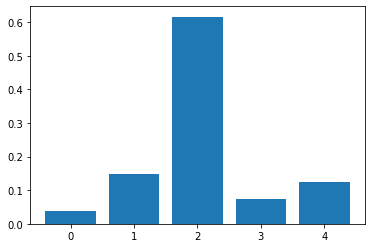

In [1453]:
image_file = 'images/canada_training/638.png' # exiting turn
result = analyze_image(image_file)
print("Dog leg right 3: ", result)
plt.bar(range(number_of_actions), result)
Image.open(image_file)

Dog leg left 1:  [0.0097122  0.0345476  0.19964875 0.03170772 0.7243837 ]


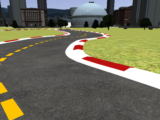

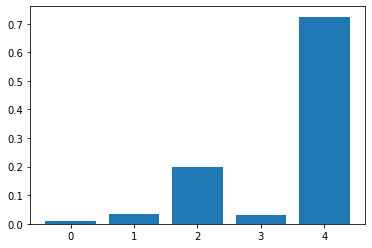

In [1454]:
image_file = 'images/canada_training/1309.png' # exiting turn
result = analyze_image(image_file)
print("Dog leg left 1: ", result)
plt.bar(range(number_of_actions), result)
Image.open(image_file)

Dog leg left 2:  [0.05164653 0.4734763  0.29366523 0.0350865  0.14612536]


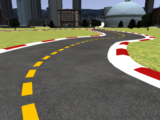

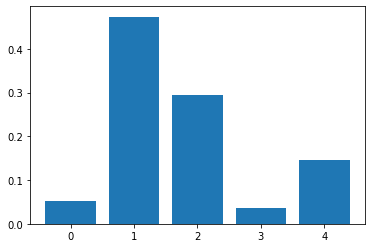

In [1443]:
image_file = 'images/canada_training/1324.png' # exiting turn
result = analyze_image(image_file)
print("Dog leg left 2: ", result)
plt.bar(range(number_of_actions), result)
Image.open(image_file)

[2.5112408e-07 1.3415484e-02 9.8658425e-01 2.2565014e-11 1.8967992e-09]


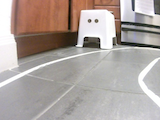

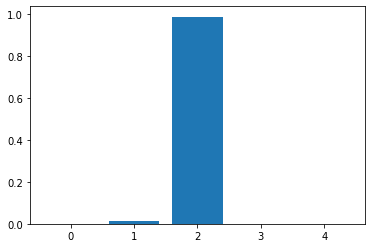

In [134]:
image_file = 'images/kitchen/5.png'
result = analyze_image(image_file)
print(result)
plt.bar(range(number_of_actions), result)
Image.open(image_file)

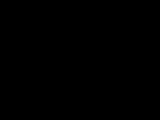

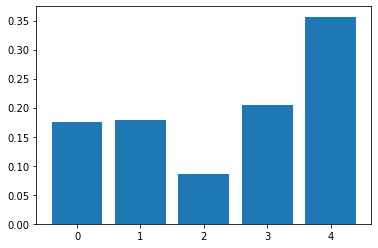

In [135]:
# Evaluate a few baseline images and see how the network behaves

#image_file = 'images/test/white.png'
image_file = 'images/test/black.png'
#image_file = 'images/test/grey.png'
#image_file = 'images/test/noise.png'
result = analyze_image(image_file)
plt.bar(range(number_of_actions), result)
Image.open(image_file)

## What is the model looking at?

Gradcam: visual heatmap of where the model is looking to make its decisions. based on https://arxiv.org/pdf/1610.02391.pdf

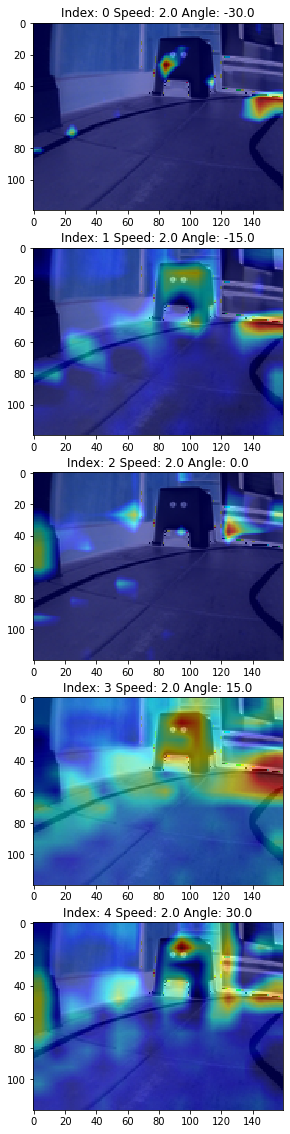

In [136]:
image = 'images/kitchen/5.png'
#image = 'images/canada_training/1680.png'
#image = 'images/canada_training/290.png'
#image = 'images/reinvent2018/1/154.png'
#image = 'images/reinvent2019/1/1714.png'
#image = 'images/reinvent2018_carpet/127.png'


plt.figure(figsize=(20,20))
# Need to loop since there are n-outputs corresponding to the number of actions
for i in range(number_of_actions):
    plt.subplot(number_of_actions, 1, i+1)
    heatmap = visualize_gradcam_discrete_ppo(model,
                                             image,
                                             category_index=i,
                                             num_of_actions=number_of_actions)
    action = action_space['action_space'][i]
    plt.title('Index: %d Speed: %0.1f Angle: %0.1f' % (i, action['speed'], action['steering_angle']))
    plt.imshow(heatmap)

# Visualize convolutional layer activations

See practical implementation at https://medium.com/@awjuliani/visualizing-neural-network-layer-activation-tensorflow-tutorial-d45f8bf7bbc4

Derived from https://arxiv.org/pdf/1506.06579.pdf

In [137]:
def getActivations(model,obs,layer,stimuli):
    units = model.run(layer, feed_dict={obs:[stimuli]})
#    units = model.run(layer,feed_dict={x:np.reshape(stimuli,[1,784],order='F'),keep_prob:1.0})
    print("Got units shape ", units.shape)
    plotNNFilter(units)
    
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

Got units shape  (1, 29, 39, 32)


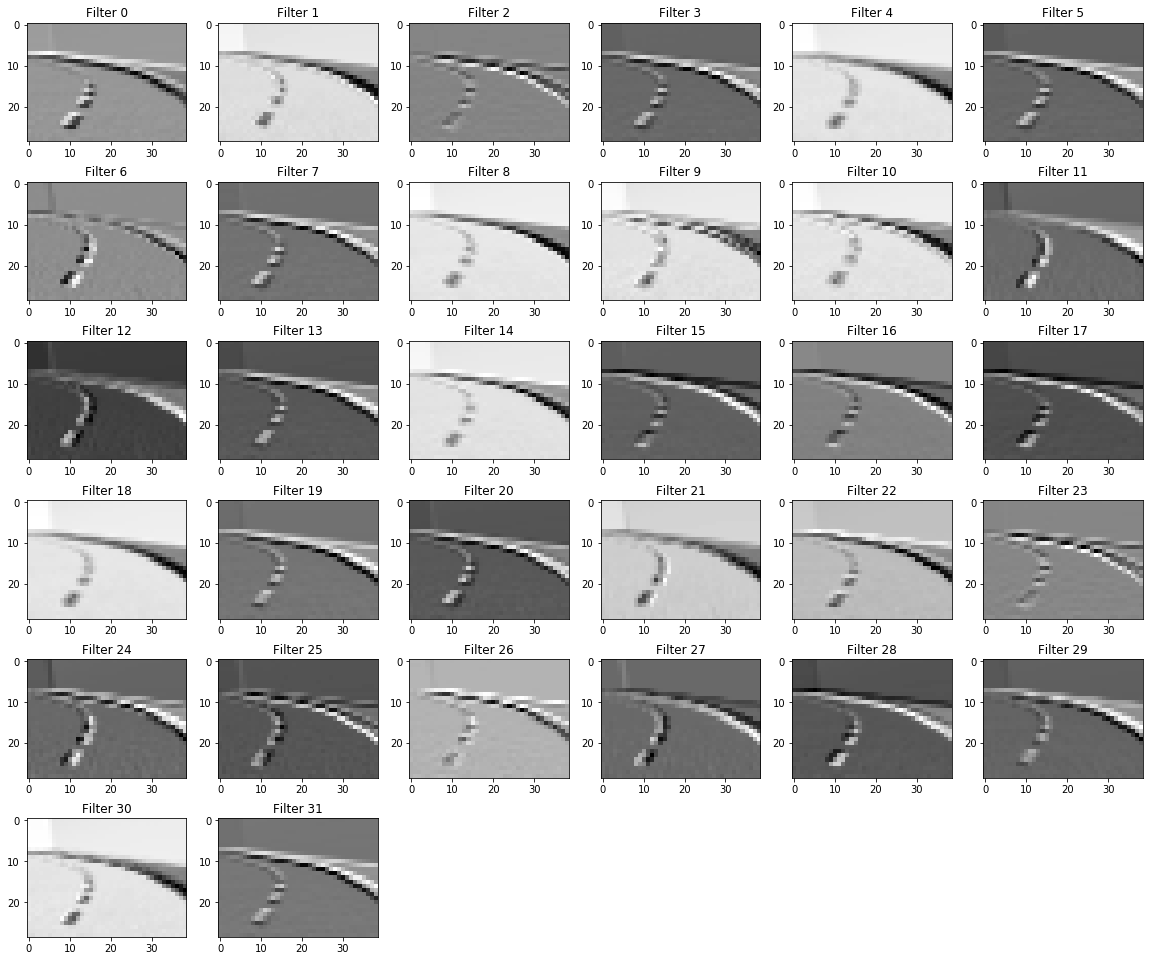

In [138]:
#image = 'images/kitchen/5.png'
#image = 'images/canada_training/1680.png'
#image = 'images/canada_training/174.png'
image = 'images/reinvent2018/1/154.png'
#image = 'images/reinvent2019/1/1714.png'
#image = 'images/reinvent2018_carpet/127.png'

image_array = image_to_npy(image)
conv_1 = model.graph.get_tensor_by_name('main_level/agent/main/online/network_1/observation/Conv2d_0/Conv2D:0')
getActivations(model, obs, conv_1, image_array)

Got units shape  (1, 13, 18, 64)


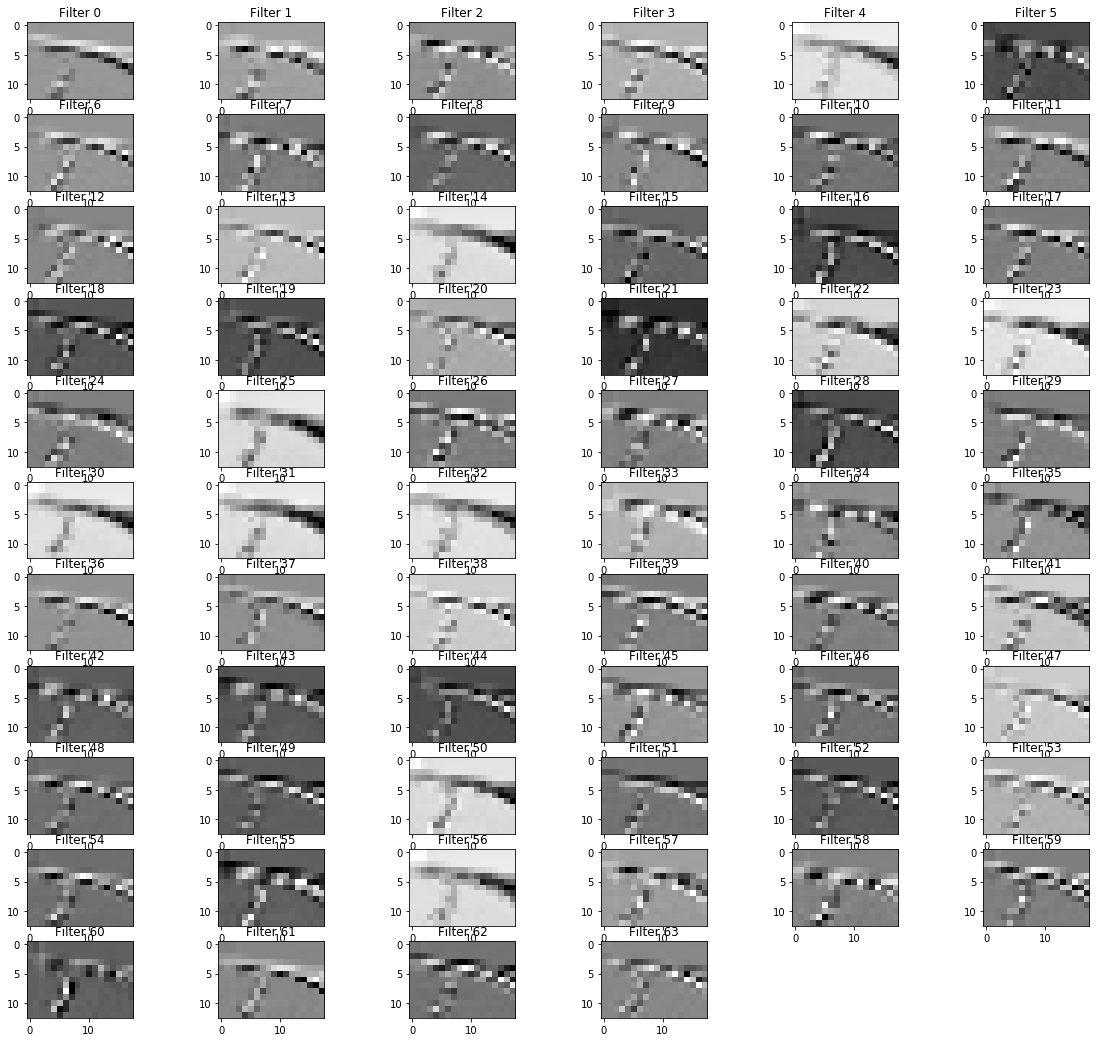

In [139]:
conv_2 = model.graph.get_tensor_by_name('main_level/agent/main/online/network_1/observation/Conv2d_2/Conv2D:0')
getActivations(model, obs, conv_2, image_array)

Got units shape  (1, 11, 16, 64)


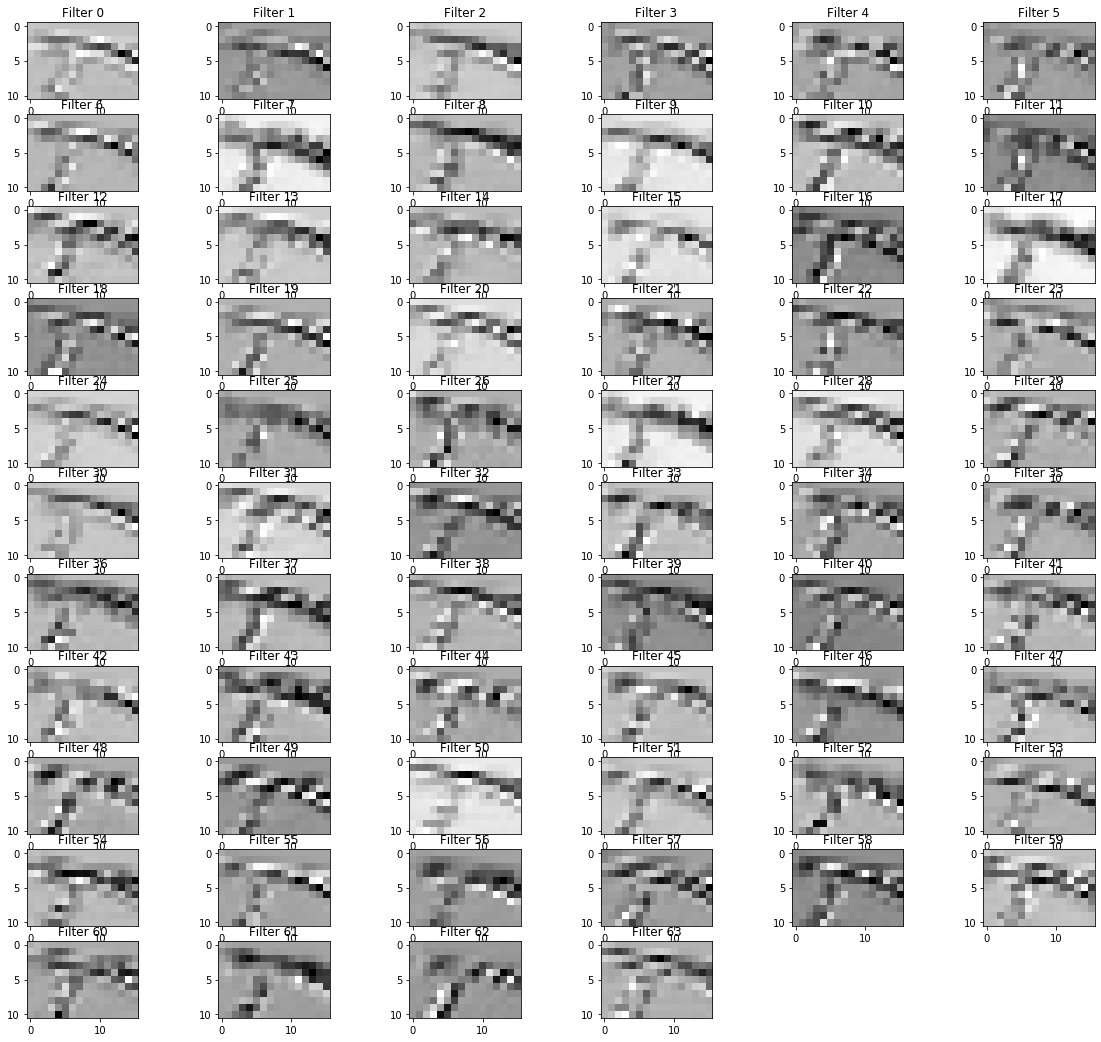

In [140]:
conv_3 = model.graph.get_tensor_by_name('main_level/agent/main/online/network_1/observation/Conv2d_4/Conv2D:0')
getActivations(model, obs, conv_3, image_array)

# Tensorboard

This imports a .pb model into tensorboard, which only has limited features.  The csv log file from rl coach is really necessary to inspect training metrics in tensorboard.


In [1010]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [1011]:
!python3 /usr/local/lib/python3.7/site-packages/tensorflow/python/tools/import_pb_to_tensorboard.py --model_dir=$model_path --log_dir="./"

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [1012]:
%tensorboard --logdir="./"

# t-SNE visualization (PoC: not currently working)

In [523]:
from sklearn.manifold import TSNE

In [524]:
def tsne_plot_with_labels(lowDWeights, labels, filename='tsne.png'):
    assert lowDWeights.shape[0] >= len(labels), "More labels than weights"
    plt.figure(figsize=(20, 20))  #in inches
    for i, label in enumerate(labels):
        x, y = lowDWeights[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

    plt.savefig(filename)

In [528]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 6
lowDWeights = tsne.fit_transform(finalWs)
labels = ['0','1','2','3','4','5','6','7','8','9']
plot_with_labels(lowDWeights, labels)

NameError: name 'finalWs' is not defined